# Physics-informed spectral approximation of Koopman operators: Lorenz 63 system

## Overview

This notebook illustrates the scheme for Koopman spectral analysis described in the preprint "Physics-informed spectral approximation of Koopman operators" ([arXiv:2408.05663](https://www.arxiv.org/abs/2408.05663); henceforth GV24) with an application to data generated by the Lorenz 63 (L63) system. 

Following imports and basic definitions, the notebook is split into three sections covering the following topics:
- Generation of training and test data.
- Computation of data-driven basis functions by eigendecomposition of kernel integral operators (see section 4.4 of the preprint).
- Solution of the variational eigenvalue problem for the regularized generator (definition 15 in the preprint) in the kernel eigenbasis.

The implementation in this notebook is based on the JAX backend of the NLSA library and has been tested on CPU and NVIDIA GPU platforms. The variable `EXPERIMENT` is optionally used to select between `small` and `gv24` test cases. `small` generates a training dataset of 30,000 samples and can run on a single 40GB NVIDIA A100 GPU in `numpy.float64` and `numpy.complex128` arithmetic. `gv24` generates a training dataset of 88,000 samples and reproduces the results in GV24. This case was tested on a machine with 4 40GB NVIDIA A100 GPUs. If `EXPERIMENT` is set to `None` parameter values must be set by the user in the relevant cells of the notebook.

## Imports and parameter selection

In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import nlsa.kernels as knl
import nlsa.function_algebra2 as fun
import nlsa.jax.vector_algebra as vec
import numpy as np
import os
import seaborn as sns
import time
from diffrax import Dopri5, ODETerm, PIDController, SaveAt, diffeqsolve
from functools import partial
from ipywidgets import fixed, interact, IntSlider
from jax import Array, grad, jit, jvp, vmap
from jax.sharding import Mesh, NamedSharding, PartitionSpec
from jaxlib.xla_extension import Device
from math import sqrt
from more_itertools import first, last, take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import FromScalarField, compose_by, conjugate_by, \
    multiply_by, normalize, smultiply_by
from nlsa.dynamics import orbit, semigroup
from nlsa.function_algebra2 import FunctionSpace, compose, compose2, \
    make_constant
from nlsa.jax.dynamics import flow, from_autonomous, make_l63_vector_field
from nlsa.jax.matrix_algebra import MatrixAlgebra, MatrixSpace
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField, \
    VectorAlgebra 
from nlsa.jax.utils import make_batched
from nlsa.utils import swap_args
from pathlib import Path
from scipy.sparse.linalg import LinearOperator, svds
from scipy.linalg import eigh
from typing import Callable, Final, Literal, Optional, TypedDict, TypeVar

In the following, setting `IDX_GPU` to `None` will fall back to CPU execution. `FP` sets the floating point precision. We recommend using `FP = f64` (which corresponds to `jax.numpy.float64` and `jax.numpy.complex128` data types), particularly when computing large numbers of kernel eigenvectors where the corresponding eigenvalues may approach machine epsilon in `f32` arithmetic. 

Setting the variables `SAVE_TRAIN_TEST_DATA` and `SAVE_KERNEL_EIGS` to `True`, with `TRAIN_TEST_DATA_MODE` and `KERNEL_EIGS_MODE` set to `'calc'`, respectively will write the training/test data and kernel eivenvalues/eigenvectors to disk using a directory/file name structure determined from the parameters set by `EXPERIMENT`. Subsequent runs with `TRAIN_TEST_DATA_MODE` and `KERNEL_EIGS_MODE` set to `'read'` will read the saved data rather than computing them. This aspect of the notebook could be improved, in the sense that even when `KERNEL_EIGS_MODE` is set to true certain computations (e.g., tuning of the kernel parameters) are carried out that would normally not be necessary. 

The parameter `SORT_BY` selects the mode for sorting computed Koopman eigenvalue/eigenvector pairs. Option `'energy'` sorts the eigenpairs in order of increasing Dirichlet energy. Option `'frequency'` sorts them in order of increasing frequency.            

In [3]:
EXPERIMENT: Optional[Literal['small', 'gv24']] = 'small'
IDX_CPU: int = 0
IDX_GPU: Optional[tuple[int]] = (0,)
#IDX_GPU: Optional[tuple[int]] = (1,)
XLA_MEM_FRACTION: Optional[float] = '.97'
FP: Literal['f32', 'f64'] = 'f64'
SORT_BY: Literal['energy', 'frequency'] = 'energy'
DIRNAME = 'l63'
SAVE_FIGS: bool = True
SAVE_KERNEL_EIGS: bool = True
SAVE_TRAIN_TEST_DATA: bool = True
TRAIN_TEST_DATA_MODE: Literal['calc', 'read'] = 'calc'
KERNEL_EIGS_MODE: Literal['calc', 'read'] = 'calc'
DPI: int = 300
SCL: float = 0.65
INTERACTIVE: bool = False

if XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

device_cpu = jax.devices("cpu")[IDX_CPU]

if IDX_GPU is not None:
    devices = [jax.devices("gpu")[i] for i in IDX_GPU]
else:
    devices = device_cpu

match FP:
    case 'f64':
        jax.config.update("jax_enable_x64", True)
        r_dtype = jnp.float64
        c_dtype = jnp.complex128
    case 'f32':
        r_dtype = jnp.float32
        c_dtype = jnp.complex64

In [4]:
class Pars(TypedDict):
    """TypedDict containing the parameter values used in this notebook."""
    N: Literal[int]
    """Literal specifying number of training samples."""

    num_samples: int
    """Number of training samples."""

    num_spinup_samples: int
    """Number of spinup samples, used to relax training data to the Lorenz 
    attractor."""

    dt: float
    """Sampling interval for training data."""

    num_tst_samples: int 
    """Number of test samples."""

    dt_tst: float
    """Sampling interval for test data."""

    num_bandidths: int
    """Number of trial kernel bandwidth parameters."""

    log10_bandwidth_lims: tuple[int, int]
    """Log upper and lower limits of trial kernel bandwidth range."""

    bandwidth_scl: float
    """Scaling factor to multiply estimated optimal kernel bandwidth."""

    vb_bandwidth_scl: float
    """Scaling factor to multiply estimated optimal bandwidth for
    variable-bandwifth kernel.
    """

    eigs_batch_size: int
    """Batch size (number of columns) in matrix-matrix multiply offloaded to
    device (e.g., GPU) in kernel eigenvector computation.
    """
    
    num_eigs: int
    """Number of kernel eigenvalue/eigenvector pairs to compute. Must be no
    greater than num_samples."""

    num_eigs_l: int
    """Number of kernel eigenvectors to use for generator eigendecomposition.
    Must be no grater than num_eigs_l."""

    tau: float
    """Diffusion regularization parameter."""

    vgrad_batch_size: int
    """Batch size (number of vectors) in computation of directional derivatives
    of kernel eigenvectors.
    """
    
    res_z: float
    """Resolvent parameter."""

    num_eigs_k: int
    """Number of generator eigenvectors to compute."""
    
    num_eigs_m: int
    """Number of kernel eigenvectors to use for mapping into RKHS."""

In [5]:
match EXPERIMENT:
    case 'small':
        pars: Final[Pars] = {'N':  Literal[30_000],
                             'num_samples': 30_000,
                             'num_spinup_samples': 5000,
                             'dt': 5.0,
                             'num_tst_samples': 1000,
                             'dt_tst': 0.01,
                             'num_bandwidth': 128,
                             'log10_bandwidth_lims': (-3.0, 3.0),
                             'bandwidth_scl': 1.0,
                             'vb_bandwidth_scl': 1.0,
                             'eigs_batch_size': 500,
                             'num_eigs': 2000,
                             'num_eigs_l': 1000,
                             'tau': 1.0E-6,
                             'vgrad_batch_size': 500,
                             'res_z': 0.1,
                             'num_eigs_k': 200,
                             'num_eigs_m': 2000}
    case 'gv24':
        pars: Final[Pars] = {'N':  Literal[80_000],
                             'num_samples': 80_000,
                             'num_spinup_samples': 5000,
                             'dt': 3.0,
                             'num_tst_samples': 1000,
                             'dt_tst': 0.01,
                             'num_bandwidth': 128,
                             'log10_bandwidth_lims': (-3.0, 3.0),
                             'bandwidth_scl': 1.0,
                             'vb_bandwidth_scl': 1.0,
                             'eigs_batch_size': 500 ,
                             'num_eigs': 1000 ,
                             'num_eigs_l': 950 ,
                             'tau': 3.0E-5,
                             'vgrad_batch_size': 475 ,
                             'res_z': 0.1,
                             'num_eigs_k': 200,
                             'num_eigs_m': 950}
    case _:
        pars = None

The following type aliases are used for code documentation purposes. This notebook has not been checked against type checkers.

In [6]:
type A = Array  # matrix 
type A_ = Array  # sharded matrix
type R = Array  # real scalar
type Rm = Array  # m-dimensional real vector
type X = Array  # state vector
type TX = Array # tangent vector
type Xs = Array  # collection of state vectors
type Xs_ = Array  # sharded collection of state vectors
type V = Array  # observable vector  
type V_ = Array  # sharded observable vector
type Vs = Array  # collection of observable vectors
type Vs_ = Array  # sharded collection of observable vectors
type K = r_dtype | c_dtype  # type of scalars
type Ks = Array  # collection of scalars
type F[S, T] = Callable[[S], T]  # alias for univariate function

We define a few convenience functions for sharding JAX arrays and for vectorization/jit-compilation of functions.

In [7]:
def make_shard(devices: list[Device]) -> F[A, A_]:
    """Make function to shard array across devices."""
    def shard(a: A) -> A_:
        return jax.device_put_sharded(jnp.split(a, len(devices)), devices)
    return shard


def make_unshard(device: Device) -> F[A_, A]:
    """Make function to concatenate sharded array to a single device."""
    def unshard(a_: A_) -> A:
        return jnp.concatenate(jax.device_put(a_, device))
    return unshard

In [8]:
shard = make_shard(devices)
unshard = make_unshard(device_cpu)
smap = conjugate_by(fun, unshard, fun, shard)
to_cpu = partial(jax.device_put, device=device_cpu)
jvmap = compose(jit, vmap)
jvvmap = compose(jit, compose(vmap, vmap))

## Dynamical system

The [Lorenz 63](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2) dynamical system is generated by the system of differential equations on $X = \mathbb R^3$
$$\dot x(t) = \vec V(x(t)),$$
where $x(t) = (x^1(t), x^2(t), x^3(t))$ and $\vec V: X \to TX$ is a vector field with components $\vec V = (V^1, V^2, V^3)$, where
$$V^1(x) = -\sigma(x^2 - x^1), \quad V^2(x) = x^1(\rho-x^3) - x^2, \quad V^3(x) = x^1 x^2 - \beta x^3.$$
We use the standard parameter values $\beta = 8/3$, $\rho=28$, and $\sigma = 10$, leading to the characteristic "butterfly" chaotic attractor (see Figure 1 below). 

The L63 system is known to possess distinguished invariant probability measure $\mu$ (in technical terms, an SRB measure) that is supported on the [Lorenz attractor](https://doi.org/10.1016/S0764-4442(99)80439-X) and is [mixing](https://doi.org/10.1007/s00220-005-1411-9). Associated with this measure is a unitary group of Koopman operators $U^t: H \to H$ acting on the Hilbert space $H=L^2(\mu)$ by composition with the flow, i.e., 
$$U^t f = f \circ \Phi^t.$$
Because the invariant measure $\mu$ is mixing, the Koopman group on $H$ does not have any nonconstant eigenfunctions. This necessitates the use of regularization techniques to obtain approximate Koopman eigenfunctions in the space $H$.  

The scheme of GV24 regularizes the *generator* of the Koopman group---this is a skew-adjoint, unbounded operator $V\colon D(V) \to H$ defined on a dense domain $D(V) \subset H$ according to the limit
$$V f = \lim_{t\to 0} \frac{U^t f - f}{t}, \quad f \in D(V),$$
taken in the norm of $H$. Intuitively, one thinks of $V$ as a directional derivative of observables (real- or complex-valued functions of the state) along the dynamical flow. More specifically, for every continuously differentiable observable $g \in C^1(X)$ we have
$$V \circ \iota g = \iota \circ \vec V \cdot \nabla g \equiv \iota \circ \langle \vec V, dg \rangle,$$
where $\iota: C(X) \to H$ is the linear map that sends continuous functions $f \in C(X)$ to their corresponding equivalence classes with respect to $\mu$ in $H$, $dg\colon X \to T^* X$ is the differential of $g$, and $\langle\cdot, \cdot\rangle\colon TX \times TX^* \to \mathbb R$ denotes the natural pairing between tangent vectors and differential forms (dual tangent vectors) on $X$.

We can take advantage of the above relation to evaluate the action of generator on elements $f \in D(V)$ in its domain with continuously differentiable representatives, $f = \iota g$ for $g \in C^1(X)$ using automatic differentiation. In this notebook, we employ JAX's `jvp` function for forward-mode Jacobian vector-product computation to build a `directional_derivative` function that implements the map $(\vec V, g) \mapsto \vec V \cdot \nabla g$.  

In [9]:
def directional_derivative(v: F[X, TX], g: F[X, R]) -> F[X, R]:
    """Form directional derivative of function with respect to vector field."""
    def h(x: X) -> R:
        _, hx = jvp(g, (x,), (v(x),))
        return hx
    return h

In the following cell, `v` is an implementation of the L63 vector field for the standard parameter values obtained using the function `make_l63_vector_field` from the `nlsa.jax.dynamics` module. Partial evaluation of `directional_derivative` on `v` then gives the function `vgrad` that implements the partial derivative operator $\vec V \cdot \nabla$ with respect to the L63 vector field.  

In [10]:
v: F[X, TX] = make_l63_vector_field()
vgrad: Callable[[F[X, R]], F[X,R]] = partial(directional_derivative, v) 

## Training and test data

We generate traing data $x_0, \ldots, x_{N-1} \in X \equiv \mathbb R^3$ by integrating the L63 system. Formally, the samples are given by $x_n = \Phi^{n \, \Delta t}(x_0)$, where $\Phi^t\colon X \to X$ is the solution map for the L63 system at time $t \in \mathbb R$, $\Delta t >0 $ is a sampling interval, and $x_0 \in X$ is an initial condition. Let $\mu_N = \sum_{n=0}^{N-1}\delta_{x_n} / N$ be the sampling measure associated with the training data. By properties of the L63 system for the standard parameter values (in particular, existence of a unique SRB measure $\mu$) that for Lebesgue almost every (a.e.) initial condition $x_0 \in X$ the sampling measures $\mu_N$ converge to $\mu$ in the following weak sense:
$$\lim_{N\to\infty} \int_X f \, d\mu_N \equiv \lim_{N\to\infty} \frac{1}{N}\sum_{n=0}^{N-1} f(x_n) = \int_X f \, d\mu$$ 
for every continuous function $f \in C(X)$. We use $\hat H_N := L^2(\mu_N)$ to denote the $N$-dimensional Hilbert space associated with the sampling measure. This is Hilbert space is equipped with the inner product 
$$\langle f, g \rangle_{\hat H_N} := \int_X f^* g \, d\mu_N \equiv \frac{1}{N} \sum_{n=0}^{N-1} \overline{f(x_n)} g(x_n).$$

Since $\Phi^t$ is not known in closed form, in practice we work with a numerical approximation obtained from an ordinary differential equation (ODE) solver. Here, we use the JAX-native ODE library [Diffrax](https://github.com/patrick-kidger/diffrax). 

The sampling interval $\Delta t$ and number of training samples $N$ are specified by the variables `dt` and `num_samples`, respectively. Choosing `dt` signficantly greater than 1 (the approximate Lyapunov timescale of the L63 system for the standard parameters) aids the convergence of ergodic averages $\int_X f \, d\mu_N$ as the samples $x_n$ become approximately independent. At the same time, datasets generated using large `dt` tend to be less structured (appear more "noisy") as point clouds in $\mathbb R^3$. Establishing criteria for tuning `dt` so as to strike a balance between Monte Carlo convergence of ergodic averages (aided by large `dt`) vs. structured sampling of the attractor (aided by small `dt`), or an altogether different sampling strategy, is an interesting avenue for future work.

In the computations that follow, we obtain the initial point $x_0$ in the training dataset by starting from an arbitrary initial condition in $X$ and allowing the numerical trajectory to settle near the Lorenz attractor over a time interval of `num_spin * dt`, where `num_spin` corresponds to the number of "spinup" samples. The training data is stored in a JAX array `xs` of shape `(num_samples, 3)`.  We force `f64` arithmetic to generate a numerical solution with low absolute and relative error tolerances. We also force CPU execution as we found it to be considerably faster than the GPU implementation.

In [11]:
if pars is not None:
    N = pars['N']
    num_samples = pars['num_samples']
    num_spinup_samples = pars['num_spinup_samples']
    dt = pars['dt']
else:
    N = Literal[80_000]
    num_samples: N = 80_000
    num_spinup_samples = 5000
    dt = 3.0

num_total_samples = num_spinup_samples + num_samples
ninv = 1.0 / num_samples
sqrtn = sqrt(num_samples)

match TRAIN_TEST_DATA_MODE:
    case 'calc':
        start_time = time.perf_counter()
        with jax.default_device(device_cpu):
            if FP == 'f32':
                jax.config.update('jax_enable_x64', True)
            x0 = jnp.array([1.0, 1.0, 1.0])
            ts_tot = jnp.arange(0, num_total_samples) * dt
            solution = diffeqsolve(terms=ODETerm(jit(from_autonomous(v))),
                                   solver=Dopri5(),
                                   t0=0.0, t1=ts_tot[-1], dt0=dt, y0=x0,
                                   saveat=SaveAt(ts=ts_tot[num_spinup_samples-1 : -1]),
                                   stepsize_controller=PIDController(rtol=1e-8,
                                                                     atol=1e-8),
                                   max_steps=200_000_000)
            if FP == 'f32':
                jax.config.update('jax_enable_x64', False)
            xs = jnp.array(solution.ys, dtype=r_dtype)
            ts = jnp.array(solution.ts, dtype=r_dtype) 
        end_time = time.perf_counter()
        print(f"{num_total_samples} timesteps of length {dt:.3E} "
              f"took {end_time - start_time:.3E} s")
        
        if SAVE_TRAIN_TEST_DATA:
            fnames = [f"dt{dt:.2f}",
                      f"n{num_samples}",
                      "xs"]
            fname = '_'.join(fnames) + ".npy"
            pth = Path("data") / DIRNAME / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.save(pth, xs)
            print(f"Training data saved at {pth}")
            
    case 'read':
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  "xs"]
        fname = '_'.join(fnames) + '.npy'
        pth = Path("data") / DIRNAME / FP / fname
        xs = np.load(pth)
        print(f"Training data loaded from {pth}")

xs_: Xs_ = shard(xs)

35000 timesteps of length 5.000E+00 took 1.426E+02 s
Training data saved at data/l63/f64/dt5.00_n30000_xs.npy


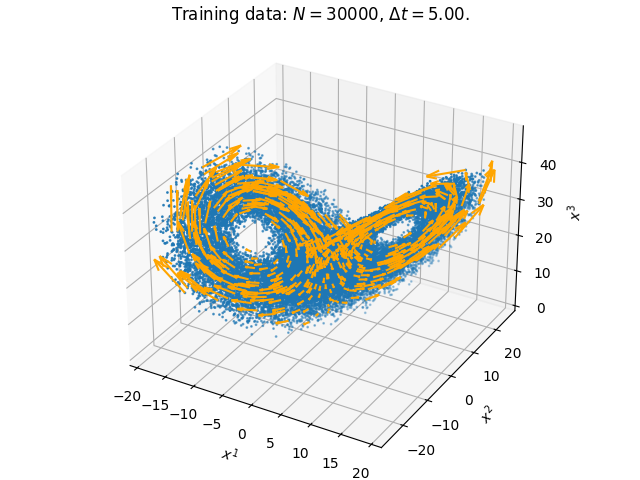

In [12]:
def plot_trainingdata(i_fig=1, num_skip=64):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
        
    fig = plt.figure(num=i_fig)
    ax = fig.add_subplot(projection='3d')
    fig.set_constrained_layout(True)
    xs_plt = xs[::num_skip, :]
    vs_plt = jvmap(v)(xs_plt)
    ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], '.', s=1)
    ax.quiver(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2],
              vs_plt[:, 0], vs_plt[:, 1], vs_plt[:, 2],
              color="orange", length=0.035)
    ax.grid()
    ax.set_title(f"Training data: $N = {num_samples}$, $\\Delta t = {dt:.2f}$.")
    ax.set_xlabel("$x^1$")
    ax.set_ylabel("$x^2$")
    ax.set_zlabel("$x^3$")
    

plot_trainingdata()

In addition to the training dataset, we generate a test dataset `xs_tst` consisting of `num_tst_samples` taken at a high temporal resolution `dt_tst` (nominally set to 0.01). We will use this dataset to perform out-of-sample evaluation of computed eigenfunctions. In particular, we choose `dt_tst` small-enough so that eigenfunctions can be meaningully visualized as time series sampled along the numerical trajectory in `xs_tst`.   

In [13]:
if pars is not None:
    num_tst_samples = pars['num_tst_samples']
    dt_tst = pars['dt_tst']
else:
    num_tst_samples = 1000
    dt_tst = 0.01

x0_tst = xs[-1]
ts_tst = jnp.arange(0, num_tst_samples) * dt_tst

match TRAIN_TEST_DATA_MODE:
    case 'calc':
        start_time = time.perf_counter()
        solution_tst = diffeqsolve(terms=ODETerm(from_autonomous(v)), solver=Dopri5(),
                                   t0=0.0, t1=ts_tst[-1], dt0=dt_tst, y0=x0_tst,
                                   saveat=SaveAt(ts=ts_tst),
                                   stepsize_controller=PIDController(rtol=1e-8,
                                                                     atol=1e-8),
                                   max_steps=200_000_000)
        xs_tst = solution_tst.ys
        ts_tst = solution_tst.ts 
        end_time = time.perf_counter()
        print(f"{num_tst_samples} timesteps of length {dt_tst:.3E} "
              f"took {end_time - start_time:.3E} s")

        if SAVE_TRAIN_TEST_DATA:
            fnames = [f"dt_tst{dt_tst:.2f}",
                      f"num_tst_samples{num_tst_samples}",
                      "xs_tst"]
            fname = '_'.join(fnames) + ".npy"
            pth = Path("data") / DIRNAME / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.save(pth, xs_tst)
            print(f"Test data saved at {pth}")

    case 'read':
        fnames = [f"dt_tst{dt_tst:.2f}",
                  f"n_tst{num_tst_samples}",
                  "xs_tst"]
        fname = '_'.join(fnames) + ".npy"
        pth = Path("data") / DIRNAME / FP / fname
        xs_tst = np.load(pth)
        print(f"Test data loaded from {pth}")

1000 timesteps of length 1.000E-02 took 2.342E+00 s
Test data saved at data/l63/f64/dt_tst0.01_num_tst_samples1000_xs_tst.npy


## Basis function computation

### Overview 

We compute orthonormal basis vectors $\phi_{0,N}, \ldots, \phi_{L-1,N}$ in $\hat H_N$ by solving the kernel eigenvalue problem
$$G_N \phi_{j,N} = \lambda_{j,N} \phi_{j,N}.$$
Here, $G_N\colon \hat H_N \to \hat H_N$ is an integral operator associated with a symmetric, strictly positive-definite, continuously differentiable ($C^1$) Markovian kernel $p_N\colon X \times X \to \mathbb R_+$, i.e.,
$$ G_N f = \int_X p_N(\cdot, x) f(x) \, d\mu_N(x) \equiv \frac{1}{N} \sum_{n=0}^{N-1} p_N(\cdot, x_n) f(x_n),$$
where the kernel satisfies $\int_X p_N(x, \cdot) \, d\mu_N = 1$ for every $x \in X$, and the eigenvalues $\lambda_{j,N}$ are real and satisfy $1 = \lambda_{0,N} > \lambda_{1,N} \geq \lambda_{2,N} \geq \cdots \geq \lambda_{L,N} > 0$.
Computationally, the eigenvectors $\phi_{j,N}$ are represented by column vectors $\vec\phi_{j,N} = (\phi_{0,j,N}, \ldots, \phi_{N-1,j,N})$ such that $\phi_{j,N}(x_i) = \phi_{i,j,N}$. 

The kernel function $p_N: X \times X \to \mathbb R_+$ is built by normalization of a variable-bandwidth ("self-tuning") kernel $k_N\colon X \times X \to \mathbb R_+$ ([Berry and Harlim 2016](https://doi.org/10.1016/j.acha.2015.01.001); see also [Zelnik-Manor and Perona 2004](https://proceedings.neurips.cc/paper_files/paper/2004/file/40173ea48d9567f1f393b20c855bb40b-Paper.pdf)),
$$k_N(x, y) = \exp\left(- \frac{\lVert x - y\rVert^2}{\epsilon^2 r_N(x) r_N(y)}\right),$$
where $r_N \colon X \to \mathbb R_+$ is a continuous bandwidth function that takes large values (i.e., decreases the locality of the kernel) in regions with low sampling density relative to the ambient volume measure of state space and vice-versa takes small values (i.e., increases the locality of the kernel) in regions with high sampling density relative to the invariant measure. We will describe the construction of $r_N$ in the next subsection, but for now note that $r_N$ depends on the training data (and thus so does $k_N$). 

To obtain $p_N$ from $k_N$, we employ a variant of a bistochastic kernel normalization procedure proposed by [Coifman and Hirn (2013)](10.1016/j.acha.2013.01.001). This involves computing the continuous functions $d_N, q_N \in C^1(X)$ and the asymmetric kernel function $\hat k_N\colon X \times X \to \mathbb R_+$ defined as
$$d_N = \int_X k_N(\cdot, x) \, d\mu_N(x), \quad q_N = \int_X \frac{k_N(\cdot, x)}{d_N(x)} \, d\mu_N(x), \quad \hat k_N(x, y) = \frac{k_N(x,y)}{d_N(x) q^{1/2}_N(y)}.$$
We then set
$$p_N(x, y) = \int_X \hat k_N(x, z ) \hat k_N(z, y) \, d\mu_N(z).$$

Defining the integral operator $\hat K_N: \hat H_N \to \hat H_N$ as
$$\hat K_N = \sum_{j=0}^{N-1} \phi_{j,N} \sigma_{j,N} \langle\gamma_{j,N}, \cdot\rangle_{\hat H_N},$$ 
we have $G_N = \hat K_N \hat K_N^*$. As a result, the eigendecomposition of $G_N$ may be obtained from the singular value decomposition (SVD) of the integral operator associated with the kernel $\hat k_N$, i.e., 
$$\hat K_N f = \int_X \hat k_N(\cdot, x) f(x) \, d\mu_N(x),$$
where $\phi_{j,N} \in \hat H_N$ are left singular vectors (equivalently eigenvectors of $G_N$), $\gamma_{j,N} \in \hat H_N$ are right singular vectors, and $\sigma_{j,N} \geq 0$ are singular values giving the eigenvalues of $G_N$ as $\lambda_{j,N} = \sigma_{j,N}^2$. Importantly, every $\phi_{j,N}$ with nonzero corresponding singular value has a continuously differentiable representative $\varphi_{j,N} \in C^1(X)$, where
$$\varphi_{j,N} = \frac{1}{\sigma_{j,N}} \int_X \hat k_N(\cdot, x) \gamma_{j,N}(x) \, d\mu_N(x) \equiv \frac{1}{\sigma_{j,N} N} \sum_{n=0}^{N-1} \hat k_N(\cdot, x_n) \gamma_{n,j,N}.$$ 
Here, $\gamma_{n,j,N}$ are the components of $N$-dimensional vectors $\mathbf\gamma_{j,N} = (\gamma_{0,j,N}, \ldots, \gamma_{N-1, j, N})$ representing $\gamma_{j,N}$. Defining $\tilde K_N: \hat H_N \to C(X)$ as the version of $\hat K_N$ mapping into continuous functions (i.e., $\hat K_N f = \int_X \hat k_N(\cdot, x)f(x) \, d\mu_N(x)$ and $\hat K_N = \iota \tilde K_N$), we can write
$$\varphi_{j,N} = \frac{1}{\sigma_{j,N}} \tilde K_{j,N} \gamma_{j,N}.$$

Next, let $\mathcal H_N \subset C(X)$ be the reproducing kernel Hilbert space (RKHS) with reproducing kernel $p_N$. It can be shown that $P_N: \hat H_N \to \mathcal H_N$ where
$$P_N f = \int_X p_N(\cdot, x) f(x) \, d\mu_N(x)$$
is a well-defined compact integral operator, and the adjoint $P_N^*: \mathcal H_N \to \hat H_N$ implements the inclusion map; that is, $P_N^* f = \iota f$. In particular, we can factorize $\hat G_N$ as $\hat G_N = P_N^* P_N$. It can also be shown that $P_N$ has the polar decomposition
$$P_N = T_N \sqrt{\hat G_N},$$
where $\sqrt{\hat G_N} : \hat H_N \to \hat H_N$ is the positive square root of $G_N$ (that is, the positive operator with eigendecomposition $\sqrt{\hat G_N} \phi_{j,N} = \sqrt{\lambda_{j,N}} \phi_{j,N}$), and $T_N: \hat H_N \to \mathcal H_N$ is an isometry satisfying
$$T_N \phi_{j,N} = \sqrt{\lambda_{j,N}} \varphi_{j,N}.$$
Observe, in particular, that
$$T_N \phi_{j,N} = \tilde K_N \gamma_{j,N},$$
so the action of $T_N$ on the left singular vectors $\phi_{j,N}$ can be understood as smoothing the corresponding right singular vectors $\gamma_{j,N}$ by the integral operator $\tilde K_N$. Defining the unitary map $\mathcal U_N : \hat H_N \to \hat H_N$ as $\mathcal U_N = \sum_{j=0}^{N-1} \gamma_{j,N} \langle \phi_{j,N}, \cdot \rangle_{\hat H_N}$ it follows from the above that
$$T_N = \tilde K_N \mathcal U_N.$$ 
Yet another way to express $T_N$ is by introducing the synthesis operator, $S_N : \mathbb C^N \to \hat H_N$, where $S_N \mathbf c = \sum_{j=0}^{N-1} c_j \gamma_j$ for $\mathbf c = (c_0, \ldots, c_{N-1}) $. Then, if $f = \sum_{j=0}^{N-1} c_j \phi_{j,N}$ we have
$$T_N f = \tilde K_N S_N \mathbf c.$$ 


The RKHS $\mathcal H_N$ also has an associated Nystrom out-of-sample extension operator, $\mathcal N_N : \hat H_N \to \mathcal H_N$, defined by linear extension of
$$\mathcal N_N \phi_{j,N} = \varphi_{j,N}.$$
By construction, this operator satisfies $P_N^* \mathcal N_N f = f$ for every $f \in \hat H_N$; that is, $\mathcal N_N$ is a right inverse of $P_N^*$. In fact, it can be shown that $\mathcal N_N$ is the Moore-Penrose pseudoinverse of the inclusion map $P_N^*$. Using the Nystrom operator, we define the Dirichlet energy $\mathcal E_N : \mathcal H_N \to \mathbb R_+$ as the functional
$$\mathcal E_N(f) = \frac{\lVert \mathcal N_N f \rVert_{\mathcal H_N}^2}{\lVert f \rVert_{\hat H_N}^2} - 1.$$
Equivalntly, for $f = \sum_{j=0}^{N-1} c_j \phi_{j,N}$, we have
$$\mathcal E_N(f) = \frac{\sum_{j=0}^{N-1} \lvert c_j \rvert^2 / \lambda_{j,N}}{\sum_{i=0}^{N-1} \lvert c_i \rvert^2}.$$
Since $\lambda_{0,N} = 1$ and $\lambda_{j,N} < 1 $ for $ j \geq 1$, it follows that $\mathcal E_N(f) \geq 0$ with equality if and only if $f$ is constant $\mu_N$-a.e. Intuitively, we think of the Dirichlet energy as a measure of "roughness" of elements in $\hat H_N$ with respect to the RKHS $\mathcal H_N$, akin to the notion of roughness captured by a Sobolev norm. 

Our computational implementation of these constructions is as follows:
- We build an object `l2x` of type `MeasureFnAlgebra` (provided by the `nlsa.jax.vector_algebra` module) that implements the basic operations of the $\hat H_N \equiv L^2(\mu_N)$ Hilbert space on JAX arrays. In particular, `l2x` has an attribute `incl` that implements the inclusion map $\iota_N: C(X) \to \hat H_N$ as a `Callable` that maps a function `f(x: X) -> R` to JAX array (type hinted as `V_`) containing the values of `f` on the sharded array `xs_` containing the training data. `f` is vectorized with `jax.vmap` and JITted with `jax.jit` prior to function evaluation. *Note that the measure implemented by `l2x` is the counting measure, which differs by the the sampling measure $\mu_N$ by a scaling factor of $N$. This requires multiplication/division by `num samples` or its square root in various places in the notebook in order to produce results consistent with $\mu_N$.*
- We use functions provided by the `nlsa.kernels` module (imported in this notebook as `knl`) to perform the various kernel normalizations described above and built associated integral operators. These include:
    1. `knl.bs_normalize` which takes as inputs a `MeasureFnAlgebra` object (here, `l2x`) and a kernel function `k` (passed as a `Callable[[X, X], R]`) and outputs a `Callable[[X, X,], R]` implementing the kernel $\hat k_N$.
    2. `knl.make_integral_operator` that takes as inputs a `MeasureFnAlgebra` object, a function `k: Callable[[X, X], R]` implementing a kernel $k\colon X \times X \to \mathbb R$ and outputs a `Callable` `k_op` such that `f = k_op(v_)` is a function of signature `f(x: X) -> R` that implements $\tilde K_N v$ for a vector $v \in \hat H_N$ represented by sharded array `v_: V_`.
    3. Given a kernel integral operator `k_op` as above. We use its composition `g_op = compose(l2x.incl, k_op)` with the inclusion map to implement the corresponding integral operators mapping $\hat H_N$ to itself (in particular, `g_op` is a `Callable[[V_], V_]`). Here, `compose` is a composition function provided by the `nlsa.abstract_algebra` module.
    4. We compute the SVD of integral operators such as `g_op` above using the `svds` iterative solver from the `scipy.sparse.linalg` module. In order to do that, we create a `scipy.sparse.linalg.LinearOperator` object that implements matrix-vector and matrix-matrix multiplication associated with `g_op` and its adjoint. Effectively, this results in offloading linear operator computations to the GPU and assembling the results into `numpy` arrays for further processing with `svds`. A possible improvement of this step would be to use a JAX-native SVD solver.    

In [14]:
scl = ScalarField(dtype=r_dtype)
l2x: MeasureFnAlgebra[X, N, K] = \
    MeasureFnAlgebra(dim=num_samples,
                     dtype=r_dtype,
                     unit=make_constant(shard(jnp.ones(num_samples,
                                                       dtype=r_dtype))),
                     measure=vec.counting_measure,
                     inclusion_map=vec.jeval_at(xs_, devices=devices))

### Kernel construction and tuning

In order to implement the basis function computation procedure described above, we first need to build the bandwidth function $\rho_N$ and tune kernel parameters such as $\epsilon$.

To build $\rho_N$, we use an adaptation of the bandwidth function construction described in [Berry and Harlim 2016](https://doi.org/10.1016/j.acha.2015.01.001). We start from a fixed-banwdith Gaussian kernel $\bar k_N: X \times X \to \mathbb R_+$ 
$$\bar k_N(x, y) = \exp\left(- \frac{\lVert x - y\rVert^2}{\tilde \epsilon^2}\right), \quad \varepsilon>0,$$
and normalize it to a Markov kernel $\bar p_N : X \times X \to \mathbb R_+$ using the normalization procedure from the diffusion maps algorithm of [Coifman and Lafon 2006](https:dx.doi.org/10.1016/j.acha.2006.04.006):
$$\bar p_N(x, y) = \frac{\tilde k_N(x, y)}{\bar d_N(x)}$$ 
with 
$$\bar d_N = \int_X \bar k(\cdot, x) \, d\mu_N(x), \quad \tilde k_N(x, y) = \frac{\bar k(x, y)}{\bar q_N(x) \bar q_N(y)}, \quad \bar q_N = \int_X k(\cdot, x) \, d\mu_N(x).$$ 
Note that the bandwidth parameter $\varepsilon$ is distinct from (but plays a similar role to) the parameter $\epsilon$ introduced in the previous subsection. We let $\tilde K_N \colon \hat H_N \to C(X)$ and $\bar P_N \colon \hat H_N \to C(X)$ denote the integral operators
$$ \tilde K_N f = \int_X \tilde k_N(\cdot, x) f(x) \, d\mu_N(x), \quad \bar P_N f = \int_X \bar p_N(\cdot, x) f(x) \, d\mu_N(x).$$

Suppose, for now, that the support of the invariant measure measure $\mu$ is contained in a closed Riemannian submanifold $M \subseteq X$, and $\mu$ has a smooth, strictly positive density $\rho = \frac{d\mu}{d\text{vol}}$ relative to the Riemmanian volume measure $\text{vol}$ on $M$. Let also $\bar p: M \times M \to \mathbb R_+$ and $\bar P : H \to C(M)$ be time-$\varepsilon$ heat kernel and associated integral operator,
$$\bar P = \int_M \bar p(\cdot, x) f(x) \, d\text{vol}(x),$$
at time parameter $t_\text{heat}$. By resuls on diffusion maps, for $N$ large and $\varepsilon$ small (where "large" and "small" can be made precise in an asymptotic sense), $\bar P_N$ can be viewed as an approximation of the heat operator for $t_\text{heat} = \varepsilon^2/4$, in the sense that $\bar P f(x) \approx \bar P_N f(x)$ for continuous $f$ and $x \in M$. It can also be shown that the function $\hat d_N$ approximates $\rho$ up to a normalization constant $C$,
$$ d_N \approx \frac{C}{\rho}.$$
Since
$$\text{vol}(M) = \int_M d\text{vol} = \int_M \frac{1}{\rho} \, d\mu,$$
it follows that given an estimate $\text{vol}_N(M)$ of the Riemannian volume $\text{vol}(M)$ we can approximate $\rho$ by 
$$\rho_N := \frac{\int_X d_N \, d\mu_N}{\text{vol}_N(M)} \frac{1}{d_N}.$$ 
Moreover, since $\rho_N$ is a density function (i.e., it has "units" of length$^{-\text{dim}(M)}$) we can obtain from it a bandwith function (with units of length) by defining
$$r_N = \rho_N^{-1/\text{dim}_N(M)},$$
where $\text{dim}_N(M)$ is an estimate of the dimension of $M$. Of course, the support of the SRB measure $\mu$ of the L63 system is not a smooth manifold (it is a fractal), but we will nonetheless use the analysis above as a heuristic argument to build the bandwidth function $r_N$ used in our variable-bandwidth kernel introduced in the previous subsection. From the manifold analogy, we can expect, for instance that $r_N$ takes large (small) values in regions of data space with small (large) concentration of samples with respect to ambient volume. Intriguingly, the numerical experiments in this notebook yield values of $\text{dim}_N(M)$ which are close to estimates $\approx 2.06$ for the [box-counting dimension](https://doi.org/10.1098/rsta.1968.0001) of the Lorenz attractor. As future work, it would be interesting to perform a more detailed analysis to understand this correspondence.         

What remains is to obtain the estimates $\text{vol}_N(M)$ and $\text{dim}_N(M)$ of Riemannian volume and intrinsic dimension. Starting from the latter, we will use the kernel tuning procedure introduced by [Coifman et al. 2008](https://doi.org/10.1109/tip.2008.2002305) and adapted to the present form in later papers ([Berry and Harlim 2016](https://doi.org/10.1016/j.acha.2015.01.001); [Berry *et al.* 2015](10.1103/PhysRevE.91.032915)). Let us use the notation $\bar k_\varepsilon$ to make the dependence of the Gaussian kernel $\bar k$ on $\varepsilon$ explicit. Defining the function $S\colon \mathbb R_+ \to \mathbb R_+$ as
$$S(\eta) = \int_X \bar k_{e^{\eta}}(x, x) \, d\mu_N(x),$$
[Coifman et al. 2008](10.1109/tip.2008.2002305) perform a scaling analysis (again under a smooth manifold assumption) that shows that for $N$ sufficiently large there is a regime where $S(\epsilon) \propto \epsilon^{\text{dim}(M)}$ exhibits power law behavior with an exponent equal to the dimension of $M$. Therefore, $b\colon \mathbb R_+ \to \mathbb R_+$ defined as $b(\eta) = S(e^{\eta})$ we may estimate  $\text{dim}(M)$ by $b(\eta)$ with $\varepsilon = e^\eta$ taken from this regime. In addition, they argue that $\tilde \epsilon$ in this regime achieves a good balance between sampling errors (which increase with decreasing $\varepsilon$ at fixed $N$) and bias errors in the scaling law (which increase with increasing $\varepsilon$ at fixed $N$). They therefore suggest choosing $\epsilon$ as the maximizer of $S(\log\epsilon)$. Another way of interpreting this procedure is to think of $b(\log\varepsilon)$ as an effective dimension of the $N$-sample dataset "seen" by the kernel at lengthscale $\varepsilon$. Maximizing $b(\log\varepsilon)$ can thus be thought of as maximizing the effective dimension of the data as with respect to the kernel.   

The cells below implement this tuning procedure using the function `make_tuning_objective` from the `nlsa.kernels` module to build a `Callable[[R], R]` named `k_tune` that implementing $b$. `make_tuning_objective` uses automatic differentiation (in this case, `jax.grad`) to compute `k_tune` from a function with signature `k_func(eta: R) -> Callable[[R], R]` that implements the Gaussian kernel $\bar k_{\varepsilon}$ as a function of $\varepsilon$. Our nominal choice of $\varepsilon$ is then the maximizer `bandwidth_opt` of `k_tune` over a set of uniformly spaced candidate values of $\eta$. In practice, this tuning procedure may overestime or underestimate good $\varepsilon$ values, so we employ a variable `bandwidth_scl` to allow adjustments of $\varepsilon$ around the automatically determined value. Our final choice for $\varepsilon$ is then `banwidth_scl * bandwidth_opt`, assigned to the variable `bandwith`.  

In [15]:
if pars is not None:
    num_bandwidth = pars['num_bandwidth']
else:
    num_bandwidth = 128

log10_bandwidth_lims: tuple[float, float] = (-3.0, 3.0)
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], num_bandwidth)
shape_func = partial(knl.make_exponential_rbf, scl)
sqdist = vec.sqeuclidean


def k_func(epsilon: float) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), sqdist)


k_tune = jit(knl.make_tuning_objective(l2x, k_func, grad))
start_time = time.perf_counter()
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth_opt = 10.0 ** log10_bandwidths[i_opt]
end_time = time.perf_counter()
print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth_opt:.3e}")
print(f"Estimated dimension: {est_dims[i_opt]:.3e}")

Kernel tuning took 3.868e+00 s
Optimal bandwidth index: 66
Optimal bandwidth: 1.313e+00
Estimated dimension: 2.047e+00


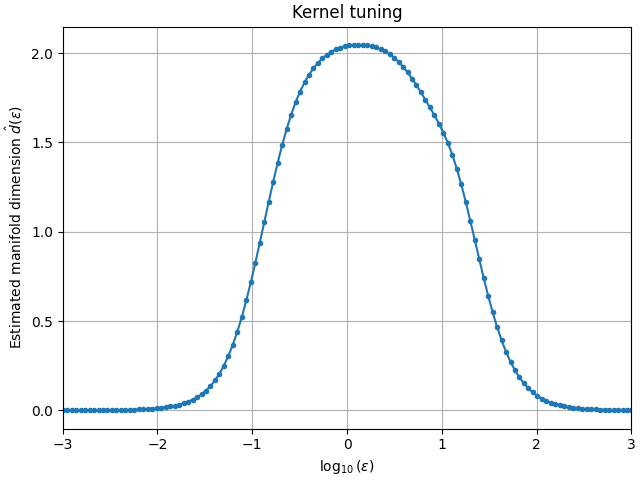

In [16]:
def plot_kernel_tuning(i_fig=2):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
        
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    ax.plot(log10_bandwidths, est_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel(r"$\log_{10}(\epsilon)$")
    ax.set_ylabel(r"Estimated manifold dimension $\hat d(\epsilon)$")
    ax.set_title("Kernel tuning")


plot_kernel_tuning()

Next, we take up the estimate $\text{vol}_N(M)$ of the Riemannian volume $\text{vol}(M)$.  

By the [Minakshisundaram-Pleijel formula](https://www.sciencedirect.com/topics/mathematics/heat-kernel) for the heat trace, we have
$$\int_M \bar p(x, x) \, d\text{vol}(x) \simeq (4 \pi t_\text{heat})^{-\text{dim}(M)/2} \text{vol}(M), \quad t_\text{heat} \ll 1.$$
Assuming that $\int_X \bar p_N(x, x) \, d\mu_N(x)$ well-approximates the heat trace $\int_X p(x, x) \, d\mu(x)$ for $t_\text{heat} = \varepsilon^2/4$ (which is suggested for the pointwise approximation result $\bar P_N f \approx \bar P f$ for $f\in C(X)$ mentioned above), we get the following asymptotic estimate for $\text{vol}(M)$,
$$\text{vol}(M) \approx \text{vol}_N(M) :=  (\pi \varepsilon^2)^{\text{dim}_N(M)/2} \int_M p_N(x, x) \, d\mu_N(x),$$
where $\text{dim}_N(M)$ is computed via bandwidth tuning procedure described above.

It should be noted that even $\text{vol}_N(M)$ is not a consistent estimator of $\text{vol}(M)$, the presence of approximation errors is inconsequential since it can be absorbed by a scaling of $\varepsilon$. In applications where $\mu$ is indeed supported on a closed manifold (e.g., ergodic torus rotation or Stepanoff flow) we have found that $\text{vol}_N(M)$ computed as above provides an accurate estimate of $\text{vol}(M)$. We have therefore opted to include $\text{vol}_N(M)$ in our definition of the bandwidth function.  

The following cell computes $\text{vol}_N(M)$ using the function `riemannian_vol` provided by the `nlsa.kernels` module. We first build a function `k: Callable[[X, X], R]` implementing the Gaussian kernel $\bar k_{\varepsilon}$ for the bandwidth parameter `bandwidth` computed in the previous step. We normalize `k` to build the diffusion-maps-normalized kernel $\bar p$ as a function `p: Callable[[X, X], R]` using the function `dm_normalize` from `nlsa.kernels`.  

In Figure 3 below, we visualize the resulting bandwifth function, `bandwidth_func` as a scatterplot on the training dataset. Note the comparatively larger values that `bandwidth_func` takes near the boundary of the attractor vs. regions away from the boundary.

In [17]:
if pars is not None:
    bandwidth_scl = pars['bandwidth_scl']
else:
    bandwidth_scl = 1.0

bandwidth = bandwidth_scl * bandwidth_opt
dim = k_tune(jnp.log10(bandwidth))
rbf: Callable[[X, X], R] = knl.make_exponential_rbf(scl, bandwidth)
k: Callable[[X, X], R] = compose(rbf, sqdist)
p: Callable[[X, X], R] = knl.dm_normalize(l2x, '1', k)
t_heat = bandwidth**2 / 4.0
fourpi = 4.0 * jnp.pi
vol = knl.riemannian_vol(l2x, p, dim, t_heat, fourpi)
bandwidth_func: F[X, R] = knl.make_bandwidth_function(l2x, k, dim, vol)
scaled_sqdist = knl.make_scaled_sqdist(l2x, sqdist, bandwidth_func)
print(f"Dimension: {dim:.3e}")
print(f"Estimated volume: {vol:.3e}")

Dimension: 2.047e+00
Estimated volume: 2.642e+03


Max. bandwidth function value: 2.285
Min. bandwidth function value: 0.162
Ratio: 14.145


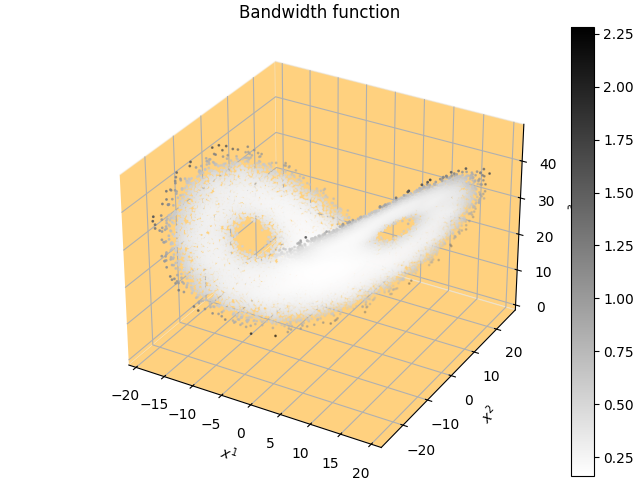

In [18]:
def plot_bandwidthfunc(i_fig: int = 3):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)

    fig = plt.figure(num=i_fig)
    ax = fig.add_subplot(projection='3d')
    fig.set_constrained_layout(True)
    plt.rcParams['grid.color'] = "yellow"    

    bw_vals = jvmap(bandwidth_func)(xs)
    bw_max = jnp.max(bw_vals)
    bw_min = jnp.min(bw_vals)
    print(f"Max. bandwidth function value: {bw_max:.3f}")
    print(f"Min. bandwidth function value: {bw_min:.3f}")
    print(f"Ratio: {(bw_max / bw_min):.3f}")
    
    sc = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=bw_vals, s=1, 
                      vmin=jnp.min(bw_vals), vmax=jnp.max(bw_vals),
                      cmap="binary")
    cx = plt.colorbar(sc)
    ax.set_xlabel("$x^1$")
    ax.set_ylabel("$x^2$")
    ax.set_zlabel("$x^3$")
    ax.xaxis.pane.set_facecolor("orange")
    ax.yaxis.pane.set_facecolor("orange")
    ax.zaxis.pane.set_facecolor("orange")
    ax.set_title("Bandwidth function") 
    plt.rcdefaults()


plot_bandwidthfunc()

Having constructed our kernel bandwidth function $r_N$, we now build the corresponding variable-bandwidth kernel, 
$$k_N(x, y) = \exp\left(- \frac{\lVert x - y\rVert^2}{\epsilon^2 r_N(x) r_N(y)}\right).$$
This kernel depends on a bandwidth parameter $\epsilon$, which we tune using the same procedure as for the fixed-bandwidth kernel $\bar k$ above. The optimal bandwidth parammeter value is assigned to the variable `vb_bandwidth_opt`, and as in the fixed-bandwidth case, we introduce a scaling factor, `vb_bandwidth_scl`, to make user-controlled adjustments. Our final bandwidth parameter value, `vb_bandwidth_scl * vb_bandwidth_opt` is assigned to `vb_bandwidth`. The associated kernel $k_N$ is implemented as function `k_vb: Callable[[X, X], R]`.

In [19]:
make_shape_func = partial(knl.make_exponential_rbf, scl)


def k_vb_func(epsilon: R) -> Callable[[X, X], R]:
    return compose(make_shape_func(epsilon), scaled_sqdist)


start_time = time.perf_counter()
k_vb_tune = jit(knl.make_tuning_objective(l2x, k_vb_func, grad))
est_vb_dims = jnp.array([k_vb_tune(epsilon)
                         for epsilon in log10_bandwidths])
i_opt_vb = jnp.argmax(est_vb_dims)
vb_bandwidth_opt = 10.0 ** log10_bandwidths[i_opt_vb]
end_time = time.perf_counter()
print(f"VB kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt_vb}")
print(f"Optimal bandwidth: {vb_bandwidth_opt:.3e}")
print(f"Estimated dimension: {est_vb_dims[i_opt_vb]:.3e}")

VB kernel tuning took 5.713e+00 s
Optimal bandwidth index: 82
Optimal bandwidth: 7.482e+00
Estimated dimension: 2.034e+00


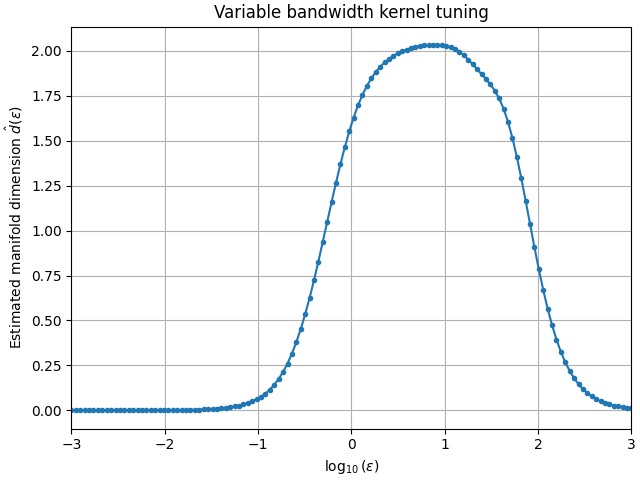

In [20]:
def plot_vbtuning(i_fig=4):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
        
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    ax.plot(log10_bandwidths, est_vb_dims, '.-')
    ax.set_xlim(log10_bandwidth_lims)
    ax.grid()
    ax.set_xlabel(r"$\log_{10}(\epsilon)$")
    ax.set_ylabel(r"Estimated manifold dimension $\hat d(\epsilon)$")
    ax.set_title("Variable bandwidth kernel tuning")


plot_vbtuning()

In [21]:
if pars is not None:
    vb_bandwidth_scl = pars['vb_bandwidth_scl']
else:
    vb_bandwidth_scl: float = 1.0

vb_bandwidth = vb_bandwidth_scl * vb_bandwidth_opt
dim_vb = k_vb_tune(jnp.log10(vb_bandwidth))
rbf_vb: Callable[[X, X], R] = knl.make_exponential_rbf(scl, vb_bandwidth)
k_vb: Callable[[X, X], R] = compose(rbf_vb, scaled_sqdist)
print(f"Variable bandwith dimention: {dim_vb:.3e}")

Variable bandwith dimention: 2.034e+00


### Singular value decomposition

We are now ready to build the integral operator $\hat K_N$ and compute its SVD. In the following cells, we use the `bs_normalize` function from the `nlsa.kernels` module to perfom bistochastic normalization of the variable-bandwidth kernel `k_vb`, leading to a kernel `k_bs` implementing $\hat k_N$ as a `Callable[[X, X], R]`. We implement the integral operators $\tilde K_N : \hat H_N \to C(X)$ and $\hat K_N : \hat H_N \to \hat H_N$ associated with $\hat k_N$ as `k_bs_op: Callable[[V_], F[X, R]]` and `g_bs_op: Callable[[V_], V_]`, respectively. `j_bs_op` is a jitted version of `g_bs_op`.  

We use the iterative SVD solver `svds` from the `scipy.sparse.linalg` module to compute the leading singular values, and associated left and right singular vectors. The results are stored in NumPy arrays `unsorted_sigmas`, `unsorted_us`, and `unsorted_vs`, of shape `(num_eigs,)`, `(num_samples, num_eigs)`, and `(num_samples, num_eigs)`, respectively, where `num_eigs` is an integer parameter specifying the number of singular values/vectors to be computed.   

The `svds` solver takes as an input a `LinearOperator` object `linop_bs` (also from `scipy.sparse.linalg`) that implements matrix-vector and matrix-matrix multiplication associated with $\hat K_N$ and its adjoint. Our implementation offloads these operations to the GPU by columnwise batching of NumPy arrays and copying the batches to sharded JAX arrays. This is carried out by means of helper functions `smap` and `make_batched` defined in the "Imports and parameter selection" section of this notebook.

The results are saved to disk if the `SAVE_KERNEL_EIGS` parameter is set to `True`. The string parameter `KERNEL_EIGS_MODE` controls whether the SVD is actually computed (parameter value `calc`) or the results are read from disk from a previous calculation (paremeter value `read`). A future improved version of this notebook could bypass the entire kernel tuning process if `KERNEL_EIGS_MODE` is set to `read`.  

In [22]:
k_bs: Callable[[X, X], R] = knl.bs_normalize(l2x, k_vb)
k_bs_op: Callable[[V_], F[X, R]] = knl.make_integral_operator(l2x, k_bs)
g_bs_op: F[V, V] = compose(l2x.incl, k_bs_op)
k_bs_transp = swap_args(k_bs)
k_bs_transp_op = knl.make_integral_operator(l2x, k_bs_transp)
g_bs_transp_op = compose(l2x.incl, k_bs_transp_op)
j_bs_op = jit(g_bs_op)
js_bs_op = jit(vmap(g_bs_op, in_axes=-1, out_axes=-1))
j_bs_transp_op = jit(g_bs_transp_op)
js_bs_transp_op = jit(vmap(g_bs_transp_op, in_axes=-1, out_axes=-1))

In [23]:
if pars is not None:
    eigs_batch_size = pars['eigs_batch_size']
else:
    eigs_batch_size = 500

make_matmat = compose(partial(make_batched, max_batch_size=eigs_batch_size,
                              in_axis=1),
                      smap)
linop = LinearOperator(shape=(num_samples, num_samples), dtype=r_dtype, 
                       matvec=smap(j_bs_op),
                       matmat=make_matmat(js_bs_op),
                       rmatvec=smap(j_bs_transp_op),
                       rmatmat=make_matmat(js_bs_transp_op))

In [24]:
if pars is not None:
    num_eigs = pars['num_eigs']
else:
    num_eigs: int = 1200
    
match KERNEL_EIGS_MODE:
    case 'calc':
        start_time = time.perf_counter()
        unsorted_us, unsorted_sigmas, unsorted_vhs = svds(linop, num_eigs)
        end_time = time.perf_counter()
        print(f"SVD took {end_time - start_time:.3e} s")

        if SAVE_KERNEL_EIGS:
            fnames = [f"dt{dt:.2f}",
                      f"n{num_samples}",
                      "eigs"]
            fname = '_'.join(fnames) + ".npz"
            pth = Path("data") / DIRNAME / FP / fname
            pth.parent.mkdir(parents=True, exist_ok=True)
            np.savez(pth,
                     unsorted_us=unsorted_us,
                     unsorted_sigmas=unsorted_sigmas,
                     unsorted_vhs=unsorted_vhs)
            print(f"Kernel eigenvalue/eigenfunction data saved at {pth}")

    case 'read':
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  "eigs"]
        fname = '_'.join(fnames) + ".npz"
        pth = Path("data") / DIRNAME / FP / fname
        kernel_eigs = np.load(pth)
        unsorted_us = kernel_eigs['unsorted_us']
        unsorted_sigmas = kernel_eigs['unsorted_sigmas'] 
        unsorted_vhs = kernel_eigs['unsorted_vhs']
        del(kernel_eigs)

SVD took 1.180e+03 s
Kernel eigenvalue/eigenfunction data saved at data/l63/f64/dt5.00_n30000_eigs.npz


In our subsequent computations, we use a subset of the largest `num_eigs_l` singular values and corresponding left/right singular vectors from the `num_eigs` singular values/vectors previously computed. This is done so as to allow experimenting with different approximation space dimensionalities (controlled by `num_eigs_l`), without having to recompute the kernel eigenbasis.  

In the following cell, `cl` is an object of type `VectorAlgebra` (defined in the `nlsa.jax.vector_algebra`) module that implements vector space operations on the space $\mathbb C^l$ of $l$-dimensional complex vectors, where $l$ is numerically equal to `num_eigs_l`. `mat_l2x_cl` is an object of type `MatrixAlgebra` (again from `nlsa.jax.vector_algebra`) that represents the space of linear operators from $\hat H_N$ to $\mathbb C^l$. 

In [25]:
if pars is not None:
    num_eigs_l = pars['num_eigs_l']
else:
    num_eigs_l = 1000

cl = VectorAlgebra(dim=num_eigs_l, dtype=c_dtype)
normalize_cl = jit(vmap(partial(normalize, cl), in_axes=1, out_axes=1))
mat_l2x_cl = MatrixSpace(hilb_in=cl, hilb_out=l2x, dtype=r_dtype)
normalize_l2x = jit(vmap(partial(normalize, l2x), in_axes=-1, out_axes=-1))

### Laplace operator

We sort the computed singular values $\sigma_{j,N}$ in descending order and store $\sigma_{1,N}, \ldots, \sigma_{l,N}$ in a JAX array `sigmas` of shape `(num_eigs_l,)`. `phis` and `gammas` are JAX arrays of shape `(num_samples, num_eigs_l)` that store the corresponding left and right singular vectors, respectively $\phi_{j,N}$ and $\gamma_{j,N}$, columnwise. We also form arrays `lambs` and `etas` of shape `(num_eigs_l,)` that contain the eigevalues $\lambda_{1,N}, \ldots \lambda_{l,N}$ and the non-negative numbers $\eta_{1,N}, \ldots, \eta_{l,N}$ defined as 
$$\eta_{j,N} = \frac{\lambda_{j,N}^{-1} - 1}{\lambda_{1,N}^{-1} -1},$$
respectively. Note that $\eta_{0,N} = 0$, and $\eta_{1,N}, \ldots, \eta_{l-1,N}$ is an increasing sequence of strictly positive numbers normalized such that $\eta_{1,N} = 1$.

In what follows, $E_{L,N} = \text{span}\{ \phi_{1,N}, \ldots, \phi_{l,N} \}$ will be the $l$-dimensional subspace of $\hat H_N$ spanned by the left singular vectors of $\hat K_N$ corresponding to $\sigma_{1,N}, \ldots, \sigma_{l,N}$ (equivalently, eigenvectors of $G_N$ corresponding to $\lambda_{1,N}, \ldots, \lambda_{l,N}$), respectively. We will use this subspace as an approximation space in which we compute approximate Koopman eigenfunctions. Note that we exclude the constant eigenfunction, $\phi_{0,N}$ from $E_{L,N}$. 

In this setup, $\eta_{j,N}$ will play the role of eigenvalues of a Laplace-type operator $\Delta_N \colon \hat H_N \to \hat H_N$, defined as a self-adjoint operator implicitly through the eigendecomposition
$$\Delta_N \phi_{j,N} = \eta_{j,N} \phi_{j,N}.$$

We plot the spectrum of Laplacian eigenvalues in Figure 5 below.

In [26]:
isort = jnp.argsort(unsorted_sigmas)
sigmas_all = unsorted_sigmas[isort[::-1]]
lambs_all = sigmas_all ** 2
etas_all = (1.0 / lambs_all - 1.0) / (1.0 / lambs_all[1] - 1.0)
us_all = unsorted_us[:, isort[::-1]]
vhs_all = unsorted_vhs[isort[::-1], :]

with jax.default_device(device_cpu):
    sigmas = jnp.array(sigmas_all[1 : (num_eigs_l+1)])
    lambs = jnp.array(lambs_all[1 : (num_eigs_l+1)])
    etas = jnp.array(etas_all[1 : (num_eigs_l+1)])
    phis = us_all[:, 1 : (num_eigs_l+1)] * sqrtn
    gammas = vhs_all[1 : (num_eigs_l+1), :].T * sqrtn

print("First 5 kernel eigevalues:")
print(lambs[0:5])
print("First 5 Laplacian eigenvalues:")
print(etas[0:5])

First 5 kernel eigevalues:
[0.9914697  0.98203842 0.97236086 0.97070342 0.94798766]
First 5 Laplacian eigenvalues:
[1.         2.12584172 3.30378589 3.5078837  6.37703173]


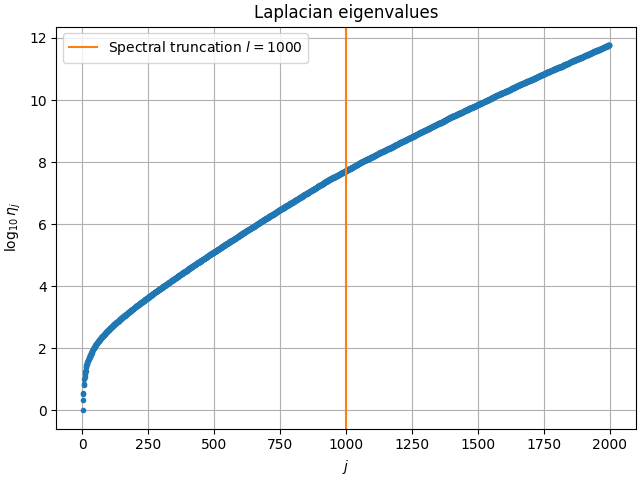

In [27]:
def plot_lapleigs(i_fig=5, num_eigs_plt=num_eigs):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)

    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    ax.plot(jnp.arange(1, num_eigs_plt), jnp.log10(etas_all[1:]), '.')
    ax.axvline(num_eigs_l, color=u'#ff7f0e',
               label=f"Spectral truncation $l = {num_eigs_l}$")
    ax.grid()
    ax.legend()
    ax.set_xlabel("$j$")
    ax.set_ylabel(r"$\log_{10}\eta_j$")
    ax.set_title("Laplacian eigenvalues")


plot_lapleigs()

### Markov semigroup

We will use the semigroup $\{G_{\tau,N} = e^{-\tau \Delta_N}\}_{\tau \geq 0}$ generated by $-\Delta_N$ to perform regularization of the generator $V$. It can be shown ([Das et al. 2021](https://doi.org/10.1016/j.acha.2021.02.004)) that for every $\tau>0$ $G_{\tau,N}$ is a self-adjoint, ergodic Markov operator on $\hat H_N$; that is, (i) $G_{\tau,N} f = f$ if and only if $f$ is constant $\mu_N$-a.e.; (ii) $G_{\tau,N}$ is positivity-preserving, i.e., $G_{\tau,N} f \geq 0$ $\mu_N$-a.e. if $f \geq 0$ $\mu_N$-a.e. By construction, $G_{\tau,N}$ has the eigendecomposition
$$G_{\tau,N} \phi_{j,N} = \lambda_{j,\tau,N} \phi_{j,N}, \quad \lambda_{j,\tau,N} = e^{-\tau \eta_{j,N}}.$$
Moreover, it can be shown that $G_{\tau,N}$ is an integral operator,
$$G_{\tau,N} f = \int_X p_{\tau,N}(\cdot, x) f(x) \, d\mu_N(x),$$
induced by a positive-definite kernel $p_{\tau,N} \colon X \times X \to \mathbb R_{\geq 0}$, where
$$p_{\tau,N}(x, y) = \sum_{j=0}^{N-1} \lambda_{j,\tau,N} \varphi_{j,N}(x) \varphi_{j,N}(y).$$

Note that we will not need to form the kernel $p_{\tau,N}$ explicitly in our computations. Nonetheless, an important theoretic property is that it is $C^r$ ($r$-times continuously differentiable) on $M\times M$ whenever $p_N$ is $C^r$. As a result, every element in the range of $G_{\tau/2}$ has a $C^1$ representative. This means, in particular, that so long as $r \geq 1$, $\text{ran} G_\tau$ is a subspace of the domain $D(V)$ of the generator.    

We use the variable `tau` to set the regularization parameter $\tau$. We store the resulting spectrumn of eigenvalues in an array `lambs_tau` and plot it in Figure 6. General guidelines for choosing $\tau$ and $l$ are as follows:
1. Given dataset consisting of $N$ samples, $l$ should be "as large as possible," but sufficiently small such that the eigenpairs $(\lambda_{j,N}, \phi_{j,N})$, as well as their directional derivatives $ \vec V \cdot \nabla \varphi_{j,N}$ (computed below), are not affected by sampling errors. The goal is to strike a balance between bias errors (which decrease with increasing $l$) and sampling errors (which generally increase with increasing $l$ at fixed $N$). 
2. For the given choice of $l$, $\tau$ should be "as small as possible" but sufficiently large such that $\lambda_{j,\tau,N} \ll 1$. Such a choice reduces the sensitivity of our operator approximations to the approximation space dimension $l$.  

In [28]:
if pars is not None:
    tau = pars['tau']
else: 
    tau = 1.0E-5

with jax.default_device(device_cpu):
    lambs_tau_all = jnp.exp(-0.5 * tau * etas_all)
    lambs_tau = lambs_tau_all[1 : (num_eigs_l+1)]

/tmp/ipykernel_1409395/411278860.py:5: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.arange(1, num_eigs_plt), np.log10(lambs_tau_all[1 : num_eigs_plt]),
/tmp/ipykernel_1409395/411278860.py:14: RuntimeWarning: divide by zero encountered in log10
  ax.set_ylim((max(-10.0, np.log10(lambs_tau_all[num_eigs_plt-1])), 1.0))


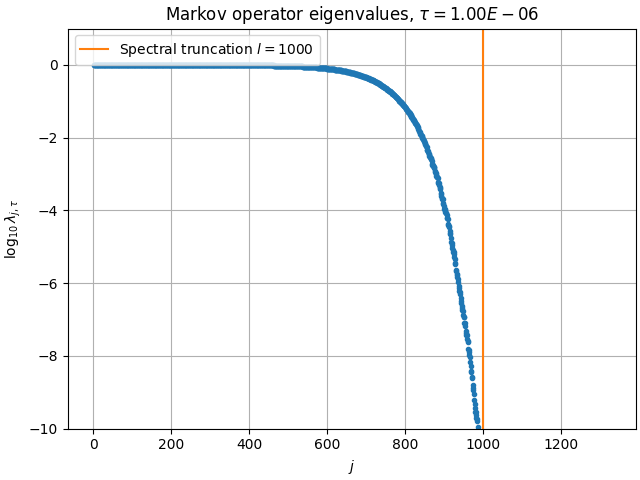

In [29]:
def plot_markoveigs(i_fig=6, num_eigs_plt=num_eigs):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True)
    ax.plot(np.arange(1, num_eigs_plt), np.log10(lambs_tau_all[1 : num_eigs_plt]),
            '.')
    ax.axvline(num_eigs_l, color=u'#ff7f0e',
               label=f"Spectral truncation $l = {num_eigs_l}$")
    ax.grid()
    ax.legend()
    ax.set_xlabel("$j$")
    ax.set_ylabel(r"$\log_{10}\lambda_{j,\tau}$")
    ax.set_title(f"Markov operator eigenvalues, $\\tau={tau:.2E}$");
    ax.set_ylim((max(-10.0, np.log10(lambs_tau_all[num_eigs_plt-1])), 1.0))


plot_markoveigs()

### Eigenfunction gradients

Recall the formula for the $C^1$ representatives of the eigenfunctions $\phi_{j,N}$ given in the "Overview" subsection above:
$$\varphi_{j,N} = \frac{1}{\sigma_{j,N}} \int_X \hat k_N(\cdot, x) \gamma_{j,N}(x) \, d\mu_N(x) \equiv \frac{1}{\sigma_{j,N} N} \sum_{n=0}^{N-1} \hat k_N(\cdot, x_n) \gamma_{n,j,N}.$$ 
Observe that in order to compute the directional derivative $\varphi'_{j,N} := \vec V \cdot \nabla \varphi_{j,N}$ it suffices to compute the directional derivative $\hat k'_N(\cdot, x) = \vec V \cdot \nabla \hat k_N(\cdot, x)$. In particular, we have
$$\varphi'_{j,N} = \frac{1}{\sigma_{j,N}} \tilde K'_N \gamma_{j,N},$$
where $\tilde K_N': \hat H_N \to C(X)$ is the integral operator with kernel $\hat k'_N$,
$$ \tilde K_N' f = \int_X \hat k'_N(\cdot, x) f(x) \, d\mu_N(x) = \frac{1}{\sigma_{j,N} N} \sum_{n=0}^{N-1} \hat k'_N(\cdot, x_n) f(x_n).$$
We will let $\phi'_{j,N} = \iota\varphi_{j,N}$ denote the $\hat H_N$ element represented by $\varphi'_{j,N}$.  

In the preceding cells, we have already implemented the kernel $\hat k_N$ as `k_bs: Callable[[X, X], R]` and the associated integral operator $\tilde K_N: \hat H_N \to C^1(M)$ as `k_bs_op: Callable[V_, F[X, R]]`. We can therefore leverage JAX's automatic differentiation capabilities to implement $\tilde K_N'$ as a composition of the directional derivative function `vgrad` with `k_bs_op`. Below, we call the resulting operator `vgrad_k_bs_op`. Using this operator we can implement $\varphi'_{j,N}$ as `vgrad_k_bs_op(gammas[:, j] / sigmas[j])`, in accordance with the analytical formula given above. We also form the composition of `vgrad_k_bs_op` with the inclusion map to obtain an operator `vgrad_g_bs_op: Callable[[V_], V_]` that maps vectors directly to vectors (analogously to `g_bs_op`).      

In Figure 7 we plot representative eigenfunctions $\varphi_{j,N}$ and their directional derivaties $\varphi'_{j,N}$. We visualize these eigenfunction as (i) scatterplots of the vectors $\phi_{j,N}$ and $\phi'_{j,N}$ on the training dataset; and (ii) time series plots of $\varphi_{j,N}$ and $\varphi'_{j,N}$ sampled on the test dataset. We also plot the $(x^1, x^2)$ coordinates of the test trajectory `xs_tst` as green lines for reference.  

In [30]:
vgrad_k_bs_op = compose(vgrad, k_bs_op)
vgrad_g_bs_op = compose(l2x.incl, vgrad_k_bs_op)

Figure saved at figs/l63/f64/dt5.00_n30000_phi13.png


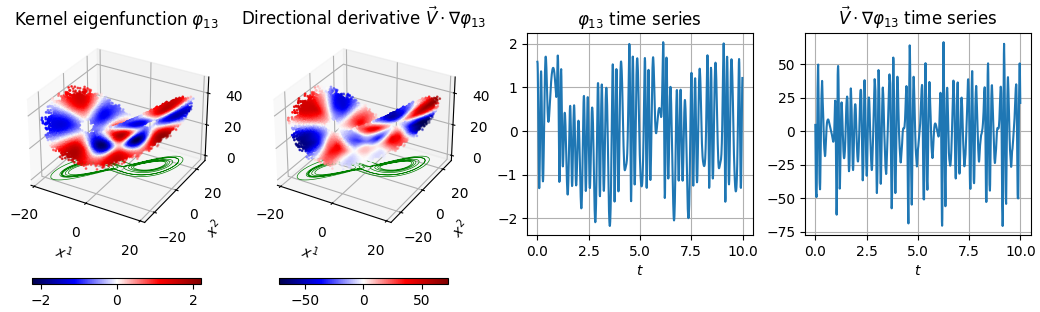

In [49]:
def initfig_kernel_efuncs(i_fig=7):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)

    fig = plt.figure(num=i_fig, figsize=(16.0*SCL, 4.8*SCL))
    axs = (fig.add_subplot(1, 4, 1, projection='3d'),
           fig.add_subplot(1, 4, 2, projection='3d'),
           fig.add_subplot(1, 4, 3),
           fig.add_subplot(1, 4, 4))
    fig.set_constrained_layout(True)
    return fig, axs


def plot_kernel_efuncs(j, figspecs=initfig_kernel_efuncs(),
                       num_plt_samples=num_tst_samples, save_fig=SAVE_FIGS):
    fig, axs = figspecs
    [ax.cla() for ax in axs]

    ts = dt_tst * np.arange(0, num_plt_samples)
    xs_plt = xs_tst[0 : num_plt_samples]
    phi = phis[:, j]
    gamma = shard(gammas[:, j] / sigmas[j])
    vgrad_phi = jit(vgrad_g_bs_op)(gamma) 
    varphi = k_bs_op(gamma)
    vgrad_varphi = vgrad_k_bs_op(gamma)
    phi_ts = jvmap(varphi)(xs_plt)
    vgrad_varphi_ts = jvmap(vgrad_varphi)(xs_plt)

    ax = axs[0]
    a = jnp.max(jnp.abs(phi))
    im = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=phi, s=1, vmin=-a, vmax=a,
                    cmap="seismic")
    ax.plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-', linewidth=0.5)
    try:
        fig.colorbar(im, ax=ax, cax=fig.axes[4], location='bottom',
                     shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(im, ax=ax, location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
    ax.set_xlabel("$x^1$")
    ax.set_ylabel("$x^2$");
    #ax.set_zlabel("$x^3$");
    ax.set_title(f"Kernel eigenfunction $\\varphi_{{{j}}}$") 

    ax = axs[1]
    a = jnp.max(jnp.abs(vgrad_phi))
    im = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=vgrad_phi, s=1,
                    vmin=-a, vmax=a, cmap="seismic")
    ax.plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-', linewidth=0.5)
    try:
        fig.colorbar(im, ax=ax, cax=fig.axes[5], location='bottom',
                     shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(im, ax=ax, location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
    ax.set_xlabel("$x^1$")
    ax.set_ylabel("$x^2$")
    #ax.set_zlabel("$x^3$")
    ax.set_title("Directional derivative "
                 f"$\\vec{{V}}\\cdot\\nabla\\varphi_{{{j}}}$")

    ax = axs[2]
    ax.plot(ts, phi_ts)
    ax.set_xlabel("$t$")
    ax.grid()
    ax.set_title(f"$\\varphi_{{{j}}}$ time series") 

    ax = axs[3]
    ax.plot(ts, vgrad_varphi_ts)
    ax.set_xlabel("$t$")
    ax.set_title(f"$\\vec{{V}}\\cdot\\nabla\\varphi_{{{j}}}$ time series")
    ax.grid()

    if save_fig:        
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  f"phi{j}"]
        fname = '_'.join(fnames) + ".png"
        pth = Path("figs") / DIRNAME / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)
        print(f"Figure saved at {pth}")


if INTERACTIVE:
    slider_kernel_efuncs = IntSlider(value=1, min=0, max=num_eigs_l-1,
                                     continuous_update=False)
    interact(plot_kernel_efuncs, 
             j=IntSlider(value=1, min=0, max=num_eigs_l-1,
                         continuous_update=False),
             figspecs=fixed(initfig_kernel_efuncs()),
             num_plt_samples=fixed(num_tst_samples),
             save_fig=fixed(SAVE_FIGS))
else:
    plot_kernel_efuncs(13)

## Spectral decomposition of the generator

### Generator matrices
Using the RKHS constructions introduced in the previous section, we build the following approximation of the generator $V$ as an operator $\hat V_N : \hat H_N \to \hat H_N$:
$$\hat V_N = P_N^* \circ (\vec V \cdot \nabla) \circ \mathcal N_N.$$  
In essence, $\hat V_N$ acts on an element $f \in \hat H_N$ by first computing its Nystrom extension $g = \mathcal N_N f \in \mathcal H_N \subset C^1(X)$, then computing the directional derivative $\vec V \cdot \nabla g$ (using automatic differentiation), and then mapping the result back to $H_N$ via the inclusion map $P_N^*$. This approximation is "physics informed" since it makes direct use of the equations of motion in the computation of $\vec V \cdot \nabla g$.   

Fix $z, \tau >0$ and consider the $l \times l$ matrices $\mathbf V_{\tau,N} = [v_{ij}]_{i,j=1}^l$ and $ \mathbf B_{z,N} = [b_{ij}]_{i,j=1}^l$ with elements  
$$\begin{aligned}
    v_{ij} &= \langle G_{\tau/2,N} \phi_{i,N}, \hat V_N G_{\tau/2,N} \phi_{j,N} \rangle_{\hat H_N} \\
    b_{ij} &= \langle (z - \hat V_N) \phi_{i,N}, (z - \hat V_N) \phi_{j,N} \rangle_{\hat H_N}.
\end{aligned}$$
Using preceding results, we get
$$\begin{aligned}
    v_{ij} &= \lambda_{i,\tau/2,N} \langle \phi_{i,N}, \phi'_{j,N} \rangle_{\hat H_N} \lambda_{j,\tau/2},\\
    b_{ij} &= \langle z \phi_{i,N} - \phi'_{i,N}, z \phi_{j,N} - \phi'_{j,N} \rangle_{\hat H_N},
\end{aligned}$$
so both $\mathbf V_{\tau,N}$ and $\mathbf B_{z,N}$ can be evaluated by computing inner products of known vectors in $\hat H_N$. Note that $\mathbf B_z$ is a positive-definite matrix. We will also need the antisymmetric part of $\mathbf V_{\tau,N}$,\
$$\mathbf A_{\tau,N} = \frac{\mathbf V_{\tau,N} - \mathbf V_{\tau,N}^\top}{2}.$$
Here, $\mathbf A_{\tau,N}$ corresponds to the matrix representation of a skew-adjoint regularized approximatiion of the generator $V$ on the subspace $E_{L,N} \subset \hat H_N$, with regularization coming by composition with the smoothing operator $G_{\tau/2,N}$. 

In the following cells, we compute the directional derivatives $\phi'_{j,N}$ in a JAX array `vgrad_phis` of shape `(num_samples, num_eigs_l)`. We then form the matrices $\mathbf A_{\tau,N}/i$ and $\mathbf B_{z,N}$ as JAX arrays `a_tau_mat`, and `b_mat`, respectively, of shape `(num_eigs_l, num_eigs_l)`. Note that we normalize $\mathbf A_{\tau,N}$ by the imaginary number $1/i$ so as to make `a_tau_mat` Hermitian. Later on this will allow us to use specialized solvers for Hermitian eigenvalue problems. 

Additional arrays formed in the cells below are `c_mat` (of shape `(num_samples, num_eigs_l)`) that stores $ z\phi_{j,N} - \phi'_{j,N}$, and `v_mat` and `a_mat` (both of shape `(num_eigs_l, num_eigs_l)`) which are versions of $\mathbf V_{\tau,N}$ and $\mathbf A_{\tau,N}$ that do not include the regularization terms $\lambda_{j,\tau2}$ associated with the eigenvalues. We perform the computation of `vgrad_phis` batchhwise to limit memory utilization of the GPU(s), and collect the result to CPU arrays. We visualize `a_mat`, `a_tau_mat`, and `b_mat` as heat maps.   

In [32]:
if pars is not None:
    vgrad_batch_size = pars['vgrad_batch_size']
else: 
    vgrad_batch_size = 100

to_vgrad_l2x_batched = make_batched(smap(jit(vmap(vgrad_g_bs_op,
                                                  in_axes=-1, out_axes=-1))),
                                    max_batch_size=vgrad_batch_size,
                                    in_axis=1)

start_time = time.perf_counter()
vgrad_phis = to_vgrad_l2x_batched(gammas / sigmas)
end_time = time.perf_counter()
print(f"Computation of {num_eigs_l} eigenfunction gradients on training data took "
      f"{end_time - start_time:.3e} s")

Computation of 1000 eigenfunction gradients on training data took 1.138e+01 s


In [33]:
if pars is not None:
    res_z = pars['res_z']
else:
    res_z = 0.1

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    v_mat = phis.T @ vgrad_phis * ninv
    a_mat = 0.5*(v_mat - v_mat.T)/1j
    a_tau_mat = lambs_tau[:, np.newaxis] * a_mat * lambs_tau
    c_mat = res_z * phis - vgrad_phis
    b_mat = c_mat.T @ c_mat * ninv
    end_time = time.perf_counter()
    
print(f"Computation of generalized eigenvalue problem matrices took "
      f"{end_time - start_time:.3e} s")

Computation of generalized eigenvalue problem matrices took 7.908e-01 s


Figure saved at figs/l63/f64/dt5.00_n30000_l1000_z0.10_tau1.00e-06_gev.png


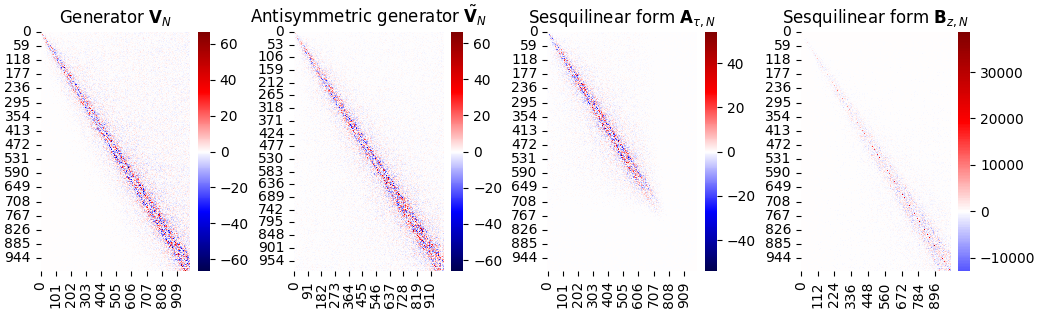

In [34]:
def plot_gev_mats(i_fig=8, save_fig=SAVE_FIGS):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
        
    fig, axs = plt.subplots(1, 4, num=i_fig, figsize=(16.0*SCL, 4.8*SCL),
                            constrained_layout=True)
    axv, axa, axt, axm = axs
    sns.heatmap(v_mat, ax=axv, cmap='seismic', center=0.0, robust=False)
    axv.set_title(r"Generator $\mathbf{V}_N$")
    sns.heatmap(a_mat.imag, ax=axa, cmap='seismic', center=0.0, robust=False)
    axa.set_title(r"Antisymmetric generator $\mathbf{\tilde{V}}_N$")
    sns.heatmap(a_tau_mat.imag, ax=axt, cmap='seismic', center=0.0, robust=False)
    axt.set_title(r"Sesquilinear form $\mathbf{A}_{\tau,N}$")
    sns.heatmap(b_mat, ax=axm, cmap='seismic', center=0.0, robust=False)
    axm.set_title(r"Sesquilinear form $\mathbf{B}_{z,N}$")

    if save_fig:        
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  f"l{num_eigs_l}",
                  f"z{res_z:.2f}",
                  f"tau{tau:.2e}",
                  "gev"]
        fname = '_'.join(fnames) + ".png"
        pth = Path("figs") / DIRNAME / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches="tight", dpi=DPI)
        print(f"Figure saved at {pth}")


plot_gev_mats()

### Generalized eigenvalue problem

Consider now the matrix generalized eigenvalue problem
$$\mathbf A_{\tau, N} \mathbf c_j = \beta_{j,z,\tau,l,N} \mathbf B_{z,N} \mathbf c_j,$$
where $\beta_{j,z,\tau,N} \in \mathbb C$ are eigenvalues and $\mathbf c_j = (c_{0j}, \ldots, c_{l-1,j})^\top \in \mathbb C^l$ are generalized eigenvectors. Since $\mathbf A_{z,N}$ is skew-symmetric and $\mathbf B_{z,N}$ is symmetric positive-definite, the eigenvalues $\beta_{j,z,\tau,N}$ are purely imaginary. 

Define the vectors $u_{j,z,\tau,l,N} \in \hat H_N$ to have expansion coefficients $\mathbf c_j$ with respect to the kernel eigenbasis $\phi_{j,\tau,N}$ of $E_{L,N}$: 
$$u_{j,z,\tau,l,N} = \sum_{i=1}^l c_{ij} \phi_{j,N}.$$
Define also 
$$\xi_{j,z,\tau,l,N} = (z - \hat V_N) u_{j,z,\tau,l,N}$$
and note that $\{\xi_{1,z,\tau,N}, \ldots, \xi_{l,z,\tau,N}\}$ is an orthonormal basis of $E_{L,N}$ by orthonormality of $\mathbf c_j$. 

The approach of GV24 assigns to each eigenvalue $\beta_{j,z,\tau,l,N}$ a (real) frequency
$$\omega_{j,z,\tau,l,N} = \frac{1 + \sqrt{1 + 4 z^2 \beta_{j,z,\tau,l,N}^2}}{2\beta_{j,z,\tau,l,N}/i}.$$
Using these frequencies and the corresponding orthonormal vectors $\xi_{j,z,\tau,l,N}$ we define a skew-adjoint operator $V_{z,\tau,l,N} : E_{L,N} \to E_{L,N}$ via the eigendecomposition
$$V_{z,\tau,l,N} \xi_{j,z,\tau,l,N} = i \omega_{j,z,\tau,l,N} \xi_{j,z,\tau,l,N}.$$

It is shown that in the iterated limit $l\to\infty$ after $N\to\infty$, $V_{z,\tau,l,N}$ converges to a skew-adjoint operator $V_{z,\tau} : D(V_{z,\tau}) \to H$ on $H$ with compact resolvent (and thus discrete spectrum). The operators $V_{z,\tau}$ are then shown to converge to the Koopman generator $V$ in the iterated limit $z\to 0^+$ after $\tau \to 0^+$. On the basis of these facts, we view $\omega_{j,z,\tau,l,N}$, $\xi_{j,z,\tau,l,N})$ as approximate Koopman eigenfrequenfies and eigenfunctions, respectively. 



In the following cells, we solve the generalized eigenvalue problem for $(\beta_{j,z,\tau,l,N}, u_{j,z,\tau,l,N})$ using the `eigh` Hermitian eigensolver from the `scipy.linalg` module. Note that we can use this solver since we normalized `a_tau_mat` to be Hermitian and `b_mat` is Hermitian positive-definite. Thus, the eigenvalues we compute are equal to $\beta_{j,z,\tau,l,N}/i$. We sort the computed eigenpairs either in order of increasing frequency modulus $\lvert \omega_{j,\tau,l,N} \rvert$, or in order of increasing Dirichlet energy $\mathcal E_N(\xi_{j,z,\tau,l,N})$. These options are selected by setting the parameter `SORT_BY` to `frequency` or `energy`, respectively. 

We store the sorted frequencies $\omega_{j,z,\tau,l,N}$ in a JAX array `eigenfreqs` of shape `(num_eigs_l,)` and the corresponding generalized eigenvectors $\mathbf c_j$ columnwise in an array `gevecs` of shape `(num_eigs_l, num_eigs_l)`. The eigenvectors are normalized to unit norm in $\mathbb C^l$. In addition, we store the Dirichlet energies $\mathcal E_N(\xi_{j,z,\tau,l,N})$ in an array `engys` of shape `(num_eigs_l,)`. In Figure 9, we visualize the spectrum of $V_{z,\tau}$ as a scatterplot of eigenfrequencies colored by the corresponding Dirichlet energies. Note that the eigenfrequencies come in sign-conjugate pairs (i.e., $\omega_{1,z,\tau,l,N} = -\omega_{0,z,\tau,lN}$, $\omega_{3,z,\tau,l,N} = - \omega_{2,z,\tau,l,N}$, ...) and the corresponding eigenvectors $\xi_{j,z,\tau,l,N}$ form complex-conjugate pairs.    

In [35]:
start_time = time.perf_counter()
unsorted_gevals, unsorted_gevecs = eigh(a_tau_mat, b_mat)
end_time = time.perf_counter()
print(f'Generalized eigenvalue problem took {end_time - start_time:.3e} s')

Generalized eigenvalue problem took 5.072e-01 s


In [36]:
with jax.default_device(device_cpu):
    unsorted_gevecs = normalize_cl(unsorted_gevecs)
    unsorted_engys = jnp.sum(jnp.abs(unsorted_gevecs)**2 \
                             / lambs[:num_eigs_l, jnp.newaxis],
                             axis=0) - 1.0

    match SORT_BY:
        case 'frequency':
            isort_gen = jnp.argsort(jnp.abs(unsorted_gevals.real))[::-1]
        case 'energy':
            isort_gen = jnp.argsort(unsorted_engys)
    
    gevals = jnp.array(unsorted_gevals[isort_gen])
    res_evals = gevals.real
    eigenfreqs = (1.0 + jnp.sqrt(1.0 - 4.0 * res_z**2 * res_evals**2)) \
        / (2.0 * res_evals)
    engys = unsorted_engys[isort_gen]
    gevecs = unsorted_gevecs[:, isort_gen]

with jnp.printoptions(precision=3, suppress=True):
    num_print = min(70, num_eigs_l)
    print('Eigenfrequencies and Dirichlet energies:')
    print(jnp.hstack((jnp.arange(num_print)[:, jnp.newaxis],
                      eigenfreqs[:num_print, jnp.newaxis],
                      engys[:num_print, jnp.newaxis])))

Eigenfrequencies and Dirichlet energies:
[[   0.       2.339   15.084]
 [   1.      -2.339   15.084]
 [   2.      -2.719   32.39 ]
 [   3.       2.719   32.39 ]
 [   4.       3.409   80.853]
 [   5.      -3.409   80.853]
 [   6.       3.842  109.947]
 [   7.      -3.842  109.947]
 [   8.       9.909  202.102]
 [   9.      -9.909  202.102]
 [  10.       5.037  223.812]
 [  11.      -5.037  223.812]
 [  12.      -5.811  240.815]
 [  13.       5.811  240.815]
 [  14.       5.375  279.902]
 [  15.      -5.375  279.902]
 [  16.      -7.78   348.009]
 [  17.       7.78   348.009]
 [  18.     -10.345  372.189]
 [  19.      10.345  372.189]
 [  20.      10.163  389.717]
 [  21.     -10.163  389.717]
 [  22.      -9.498  406.553]
 [  23.       9.498  406.553]
 [  24.     -11.931  408.314]
 [  25.      11.931  408.314]
 [  26.       7.367  408.58 ]
 [  27.      -7.367  408.58 ]
 [  28.       6.303  412.823]
 [  29.      -6.303  412.823]
 [  30.       7.154  467.613]
 [  31.      -7.154  467.613]

Figure saved at figs/l63/f64/dt5.00_n30000_m1000_z0.10_tau1.00e-06_spec.png


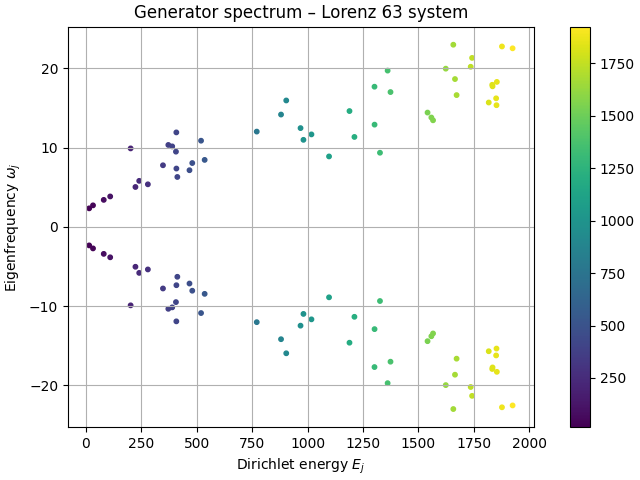

In [37]:
def plot_generator_spec(i_fig=9, num_plt=num_eigs_l, save_fig=SAVE_FIGS):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
        
    fig, ax = plt.subplots(num=i_fig, constrained_layout=True,
                           figsize=(6.4*1.0, 4.8*1.0))
    im = ax.scatter(engys[:num_plt], eigenfreqs[:num_plt], s=10,
                    c=engys[:num_plt])
    fig.colorbar(im, ax=ax)
    ax.grid(True)
    ax.set_xlabel("Dirichlet energy $E_j$")
    ax.set_ylabel(r"Eigenfrequency $\omega_j$")
    ax.set_title("Generator spectrum \u2013 Lorenz 63 system") 

    if save_fig:        
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  f"m{num_eigs_l}",
                  f"z{res_z:.2f}",
                  f"tau{tau:.2e}",
                  "spec"]
        fname = '_'.join(fnames) + ".png"
        pth = Path("figs") / DIRNAME / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches="tight", dpi=DPI)
        print(f"Figure saved at {pth}")

plot_generator_spec(num_plt=100)

### Eigenfunctions in $L^2$ and the RKHS

Given the generalized eigenvectors $\mathbf c_j$, we can compute the eigenfunctions $\xi_{j,z,\tau,l,N} \in H_N$ as the linear combination
$$\xi_{j,z,\tau,l,N} = \sum_{k=1}^l (z \phi_{k,N} - \phi'_{k,N}) c_{kj}.$$
Numerically, this can be accomplished by multiplication of the $j$-th column of `gevecs` (which stores $\mathbf c_j$) by the matrix `c_mat` (whose columns store $z \phi_{j,N} - \phi'_{j,N}$). We compute the first `num_eigs_k` eigenfunctions $\xi_{j,z,\tau,l,N}$ and store them columnwise in an array `xis` of shape `(num_samples, num_eigs_k`). We normalize the $\xi_{j,z,\tau,l,N}$ to have unit norm in $\hat H_N$. 

In [38]:
if pars is not None:
    num_eigs_k = pars['num_eigs_k']
else:
    num_eigs_k = num_eigs_l

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    xis = normalize_l2x(c_mat @ gevecs[:, :num_eigs_k]) * sqrtn
    end_time = time.perf_counter()
    
print(f"Computation of {num_eigs_k} generator eigenvectors on training data took "
      f"{end_time - start_time:.3e} s")

Computation of 200 generator eigenvectors on training data took 2.422e-01 s


In addition to eigenfunctions in $\hat H_N$, we are interested in their RKHS images $\zeta_{j,z,\tau,l,N} := T_N \xi_{j,z,\tau,l,N}$ under the isometry $T_N: \hat H_N \to \mathcal H_N$. To compute these functions, let 
$$v_{ij} = \langle \phi_i, \hat V_N \phi_j \rangle_{\hat H_N} = \langle \phi_i, \phi'_j \rangle_{\hat H_N}$$
as above, and observe that 
$$\xi_{j,z,\tau,l,N} = \sum_{i=0}^{N-1} d_{ij} \phi_{i,N}, \quad d_{ij} = z c_{ij} - \sum_{k=1}^l v_{ik} c_{kj}.$$
As a result, using expressions for $T_N$ from the previous section, we get 
$$\zeta_{j,z,\tau,l,N} = \tilde K_N \left( \sum_{i=0}^{N-1} d_{ij} \gamma_{i,N} \right).$$

An issue with this expression for $\zeta_{j,z,\tau,l,N}$ is that it requires computation of $N$ kernel eigenvectors $\phi_{i,N}$, which can be prohibitively expensive and prone to sampling errors. In response, fixing a parameter $m \leq N - 1$, we approximate $\zeta_{j,z,\tau,l,N}$ by 
$$\zeta_{j,z,\tau, l, m, N} = \tilde K_N S_{m, N} \mathbf d_j,$$
where $\mathbf d_j = (d_{0j}, \ldots, d_{m -1, j})$ and $S_{m,N} : \mathbb C^{m} \to \hat H_N$ is a spectrally truncated synthesis operator, 
$$S_{m,N} \mathbf d_j  = \sum_{i=0} ^{m -1} d_{ij} \gamma_{i,N}.$$
We then have that $\zeta_{j,z,\tau,l,m,N} = \zeta_{j,z,\tau,l,N}$. 

In the following cell, we set the truncation parameter $m$ through the integer parameter `num_eigs_m`. We compute the coefficients $d_{ij}$ for $i \in \{0, \ldots, m-1\}$ and store them in a JAX array `zetas_coeffs` of shape `(num_eigs_m, num_eigs_k)`. Using these coefficients we can build the RKHS functions $\zeta_{j,z,\tau,l,m,N}$ using the formula given above based on the integral operator $\tilde K_N$ and the synthesis operator $S_{m,N}$. We will form these functions "on demand" when we wish to plot them later on, but for now we define a function `rkhs_synth` that takes in a vector of expansion coefficients as input and applies to it $S_{m,N}$ followed by $\tilde K_N$ to produce an RKHS function.

We also compute the $\hat H_N$ vectors $\vec \zeta_{j,z,\tau,l,m,N} := P_N^* \zeta_{j,z,\tau,l,m,N}$ represented by $\zeta_{j,z,\tau,l,m,N}$, and store them in array `zetas_l2` of shape `(num_samples, num_eigs_k)`. These vectors contain the values of $\zeta_{j,z,\tau,l,m,N}$ on the training dataset and we will use them for comparison with $\xi_{j,z,\tau,l,N}$ in plots below. For the computation of `zetas_l2` we use the expansion
$$\vec\zeta_{j,z,\tau,l,m,N} = \sum_{i=0}^{m-1} d_{ij} \sigma_{i,N} \phi_{i,N}.$$
Observe the decay (smoothing) imposed by the integral operator $\tilde K_N$ by multiplicastion of the expansion coefficients $d_{ij}$ by the singular values $\sigma_{i,N}$. 

In [39]:
if pars is not None:
    num_eigs_m = pars['num_eigs_m']
else:
    num_eigs_m = num_eigs

cm = VectorAlgebra(dim=num_eigs_m, dtype=c_dtype)
mat_l2x_cm = MatrixSpace(hilb_in=cm, hilb_out=l2x, dtype=r_dtype)

with jax.default_device(device_cpu):
    start_time = time.perf_counter()
    phis_m = us_all[:, :num_eigs_m] * sqrtn
    gammas_m = vhs_all[:num_eigs_m, :].T * sqrtn
    sigmas_m = jnp.array(sigmas_all[:num_eigs_m])
    zetas_coeffs = phis_m.T @ xis * ninv
    zetas_l2 = (phis_m * sigmas_m) @ zetas_coeffs
    end_time = time.perf_counter()
    
print(f"Computation of {num_eigs_k} generator eigenvectors on training data took "
      f"{end_time - start_time:.3e} s")

rkhs_synth = compose(k_bs_op,
                     compose(shard,
                             partial(mat_l2x_cm.app, gammas_m)))

Computation of 200 generator eigenvectors on training data took 8.756e-01 s


In Figure 10, we plot the real parts of $\xi_{j,z,\tau,l,N}$ and $\vec\zeta_{j,z,\tau,l,m,N}$ side-by-side. Notice the smoothness in $\vec\zeta_{j,z,\tau,l,m,N}$ in comparison to $\xi_{j,z,\tau,l,N}$.  

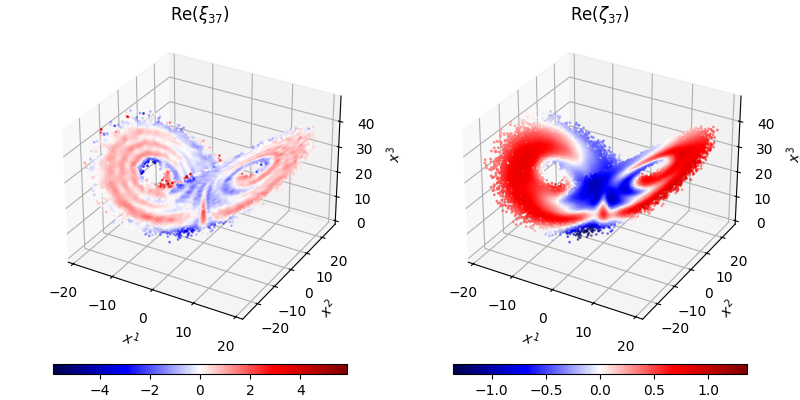

In [47]:
def initfig_xi_zeta_l2(i_fig=10):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)

    fig = plt.figure(num=i_fig, figsize=(8.0, 4.0))
    axs = (fig.add_subplot(1, 2, 1, projection='3d'),
           fig.add_subplot(1, 2, 2, projection='3d'))
    fig.set_constrained_layout(True)
    return fig, axs


def plot_xi_zeta_l2(j, figspecs=initfig_xi_zeta_l2()):
    fig, axs = figspecs
    fxss = (xis[:, j].real, zetas_l2[:, j].real)
    titles = (f"$\\mathrm{{Re}}(\\xi_{{{j + 1}}})$",
              f"$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$")
    for iax, fxs, ax, title in zip(range(len(axs)), fxss, axs, titles): 
        ax.cla()
        a = jnp.max(jnp.abs(fxs))
        sc = ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=fxs, s=1, 
                        vmin=-a, vmax=a, cmap='seismic')
        try:
            fig.colorbar(sc, ax=ax, cax=fig.axes[iax + 2], 
                         location='bottom', shrink=0.75, aspect=30.0, pad=0.07)
        except:
            fig.colorbar(sc, ax=ax, location='bottom', shrink=0.75,
                         aspect=30.0, pad=0.07)
        ax.set_xlabel("$x^1$")
        ax.set_ylabel("$x^2$")
        ax.set_zlabel("$x^3$")
        ax.set_title(title)


if INTERACTIVE:
    interact(plot_xi_zeta_l2, j=IntSlider(value=0, min=0, max=num_eigs_k-1,
                                          continuous_update=False),
             figspecs=fixed(initfig_xi_zeta_l2()))
else:
    plot_xi_zeta_l2(36)

In Figure 11, we focus on $\zeta_{j,z,\tau,l,m,N}$. We plot its real and imaginary parts as scatterplots on the training data similarly to Figure 10. In addition, we evaluate $\zeta_{j,z,\tau,l,m,N}$ on the test trajectory, and plot the results as traceplots on the complex plane and time series plots of the real and imaginary parts. For an exact Koopman eigenfunctions, the traceplot should lie in the unit circle in $\mathbb C$, and the time series plots should be perfect sinusoids with period $2\pi/ \omega_{j,z,\tau,l,m,N}$ and 90 degree phase difference. 

Figure saved at figs/l63/f64/dt5.00_n30000_l1000_z0.10_tau1.00e-06_zeta37.png


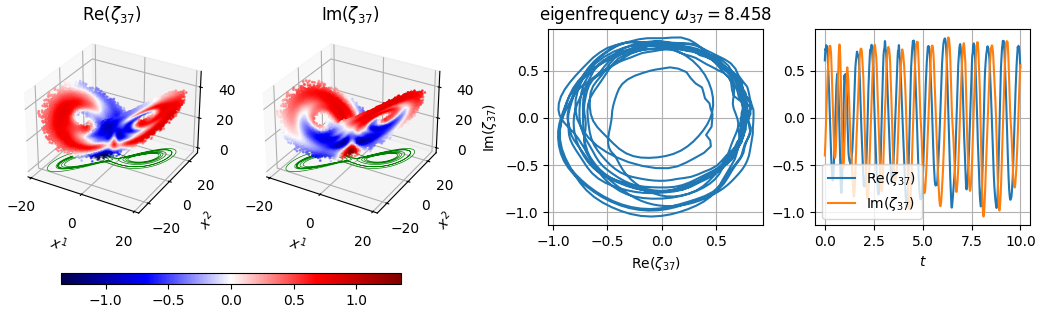

In [46]:
def initfig_zeta(i_fig=11):
    if plt.fignum_exists(i_fig):
        plt.close(i_fig)
    fig = plt.figure(num=i_fig, figsize=(16.0*0.65, 4.8*0.65))
    axs = (fig.add_subplot(1, 4, 1, projection='3d'),
           fig.add_subplot(1, 4, 2, projection='3d'),
           fig.add_subplot(1, 4, 3),
           fig.add_subplot(1, 4, 4))
    fig.set_constrained_layout(True)
    return fig, axs


def plot_zeta(j, figspecs=initfig_zeta(), num_plt=num_tst_samples,
             save_fig=SAVE_FIGS):
    fig, axs = figspecs
    ts_plt = dt_tst * jnp.arange(0, num_plt)
    xs_plt = xs_tst[0 : num_plt]
    zeta_l2 = zetas_l2[:, j]
    zeta_plt = jvmap(rkhs_synth(zetas_coeffs[:, j]))(xs_plt)
    a = max(jnp.max(jnp.abs(zeta_l2.real)), jnp.max(jnp.abs(zeta_l2.imag)))
    
    [ax.cla() for ax in axs]

    sc_re = axs[0].scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=zeta_l2.real, s=1,
                           vmin=-a, vmax=a, cmap="seismic")
    axs[0].plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-',
                linewidth=0.5)
    axs[0].set_xlabel("$x^1$")
    axs[0].set_ylabel("$x^2$")
    #axs[0].set_zlabel("$x^3$")
    axs[0].set_title(f"$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$")

    sc_im = axs[1].scatter(xs[:, 0], xs[:, 1], xs[:, 2], c=zeta_l2.imag, s=1,
                           vmin=-a, vmax=a, cmap="seismic")
    axs[1].plot(xs_plt[:, 0], xs_plt[:, 1], xs_plt[:, 2] * 0, 'g-',
                linewidth=0.5)
    axs[1].set_xlabel("$x^1$")
    axs[1].set_ylabel("$x^2$")
    #axs[1].set_zlabel("$x^3$")
    axs[1].set_title(f"$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$")

    try:
        fig.colorbar(sc_re, ax=axs[:2], cax=fig.axes[4], 
                     location='bottom', shrink=0.75, aspect=30.0, pad=0.0)
    except:
        fig.colorbar(sc_re, ax=axs[:2], location='bottom', shrink=0.75,
                     aspect=30.0, pad=0.0)
        
    axs[2].plot(zeta_plt.real, zeta_plt.imag, '-')
    axs[2].set_xlabel(f"$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$")
    axs[2].set_ylabel(f"$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$")
    axs[2].set_title(f"eigenfrequency $\\omega_{{{j + 1}}}={eigenfreqs[j]:.3f}$")
    axs[2].grid()

    axs[3].plot(ts_plt, zeta_plt.real,
                label=f"$\\mathrm{{Re}}(\\zeta_{{{j + 1}}})$")
    axs[3].plot(ts_plt, zeta_plt.imag,
                label=f"$\\mathrm{{Im}}(\\zeta_{{{j + 1}}})$")
    axs[3].set_xlabel("$t$")
    axs[3].grid()
    axs[3].legend()

    if save_fig:        
        fnames = [f"dt{dt:.2f}",
                  f"n{num_samples}",
                  f"l{num_eigs_l}",
                  f"z{res_z:.2f}",
                  f"tau{tau:.2e}",
                  f"zeta{j + 1}"]
        fname = '_'.join(fnames) + ".png"
        pth = Path("figs") / DIRNAME / FP / fname
        pth.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(pth, bbox_inches='tight', dpi=DPI)
        print(f"Figure saved at {pth}")
        

if INTERACTIVE:
    interact(plot_zeta,
             j=IntSlider(value=0, min=0, max=num_eigs_k-1,
                         continuous_update=False),
             figspecs=fixed(initfig_zeta()),
             num_plt=fixed(num_tst_samples),
             save_fig=fixed(SAVE_FIGS))
else:
    plot_zeta(36)